# Project - Solar Energy Production Forecasting
## Part 1: Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

### Import Packages

In [33]:
import os
import ast
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Memory, parallel_backend

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Warning Hygiene

In [32]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*SAMME.R.*", category=FutureWarning)  # sklearn deprecation noise
warnings.filterwarnings("ignore", message=".*No further splits with positive gain.*", category=UserWarning)  # LightGBM noise

### Load Datasets

In [2]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


UTC Time  Plant_ID  Energy_Production  Benchmark  \
0  2020-01-04 00:00:00+00:00         0                0.0        0.0   
1  2020-01-04 01:00:00+00:00         0                0.0        0.0   
2  2020-01-04 02:00:00+00:00         0                0.0        0.0   
3  2020-01-04 03:00:00+00:00         0                0.0        0.0   
4  2020-01-04 04:00:00+00:00         0                0.0        0.0   

  Day-Night  Temperature descriptor  Comfort level  Visibility  \
0         N                     4.0           1.23       17.21   
1         N                     4.0           0.28       17.39   
2         N                     4.0          -0.89       18.57   
3         N                     4.0          -1.96       19.75   
4         N                     3.0          -2.30       19.93   

   Probability of precipitation for last hour  Rainfall amount for last hour  \
0                                         1.0                            0.0   
1                                         1.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0                            0.0   
4                                         0.0                            0.0   

   Dew point  Temperature  Wind direction  Precipitation descriptor  \
0        0.0          2.5           277.0                         0   
1       -0.3          1.8           290.0                         0   
2       -0.7          0.9           297.0                         0   
3       -1.1          0.1           300.0                         0   
4       -1.4         -0.2           299.0                         0   

   Sky descriptor  Humidity  Wind speed  
0             2.0      84.0        5.04  
1             2.0      86.0        5.40  
2             2.0      89.0        5.76  
3             2.0      92.0        6.12  
4             2.0      92.0        6.12

UTC Time  Plant_ID  Energy_Production  Benchmark  \
0  2021-08-26 00:00:00+00:00         0              0.004      0.004   
1  2021-08-26 01:00:00+00:00         0              0.004      0.004   
2  2021-08-26 02:00:00+00:00         0              0.004      0.004   
3  2021-08-26 03:00:00+00:00         0              0.004      0.004   
4  2021-08-26 04:00:00+00:00         0              0.004      0.004   

  Day-Night  Temperature descriptor  Comfort level  Visibility  \
0         N                     8.0          17.50       21.32   
1         N                     8.0          17.10       19.41   
2         N                     6.0          16.50       20.50   
3         N                     6.0          15.80       20.58   
4         D                     6.0          15.65       22.67   

   Probability of precipitation for last hour  Rainfall amount for last hour  \
0                                         0.0                            0.0   
1                                         0.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0                            0.0   
4                                         0.0                            0.0   

   Dew point  Temperature  Wind direction  Precipitation descriptor  \
0       13.1         17.5           345.0                         0   
1       13.0         17.1           341.0                         0   
2       12.8         16.5           341.0                         0   
3       12.6         15.8           342.0                         0   
4       12.5         15.2           359.0                         0   

   Sky descriptor  Humidity  Wind speed  
0             7.0      76.0        6.48  
1             7.0      77.0        6.12  
2             7.0      79.0        5.76  
3             7.0      81.0        5.40  
4             8.0      84.0        5.04

### Parse timestamps, sort by time, and report missingness (`NaN`/`NaT`)

In [3]:
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [4]:
#checking for missing values
def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100)).round(2).to_frame('% of missing')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


### `df.decribe` for a better view of the Dataset

In [5]:
train_df.describe()

Plant_ID  Energy_Production     Benchmark  Temperature descriptor  \
count  176505.000000      176505.000000  176505.00000           176505.000000   
mean        7.731056           0.009563       0.00952                6.219943   
std         4.562745           0.015391       0.01537                2.003239   
min         0.000000           0.000000       0.00000                3.000000   
25%         4.000000           0.000000       0.00000                4.000000   
50%         8.000000           0.000000       0.00000                6.000000   
75%        12.000000           0.015000       0.01400                8.000000   
max        15.000000           0.071000       0.07100               12.000000   

       Comfort level     Visibility  \
count  176505.000000  176505.000000   
mean       12.226085      19.013074   
std         9.615682       8.684866   
min       -10.240000       0.000000   
25%         4.660000      14.260000   
50%        10.610000      19.200000   
75%        19.300000      23.480000   
max        39.840000      73.850000   

       Probability of precipitation for last hour  \
count                               176505.000000   
mean                                    12.133951   
std                                     18.425581   
min                                      0.000000   
25%                                      2.000000   
50%                                      5.000000   
75%                                     10.000000   
max                                     84.000000   

       Rainfall amount for last hour      Dew point    Temperature  \
count                  176505.000000  176505.000000  176505.000000   
mean                        0.010837       6.998382      12.731229   
std                         0.041445       6.926009       8.626064   
min                         0.000000     -13.100000      -7.600000   
25%                         0.000000       1.900000       6.000000   
50%                         0.000000       6.300000      11.300000   
75%                         0.000000      13.000000      19.300000   
max                         0.650000      22.700000      35.600000   

       Wind direction  Precipitation descriptor  Sky descriptor  \
count   176505.000000              1.765050e+05   176505.000000   
mean       140.857568             -4.380011e+06        9.754715   
std        112.624672              9.688588e+07        4.742879   
min          0.000000             -2.147484e+09        1.000000   
25%         38.000000              0.000000e+00        7.000000   
50%        108.000000              0.000000e+00        8.000000   
75%        224.000000              0.000000e+00       15.000000   
max        359.000000              4.600000e+01       18.000000   

            Humidity     Wind speed  
count  176505.000000  176505.000000  
mean       71.130178       7.590162  
std        17.316067       2.646163  
min        15.000000       0.160000  
25%        58.000000       5.760000  
50%        75.000000       7.200000  
75%        86.000000       8.640000  
max        99.000000      27.000000

### Plot average and total production

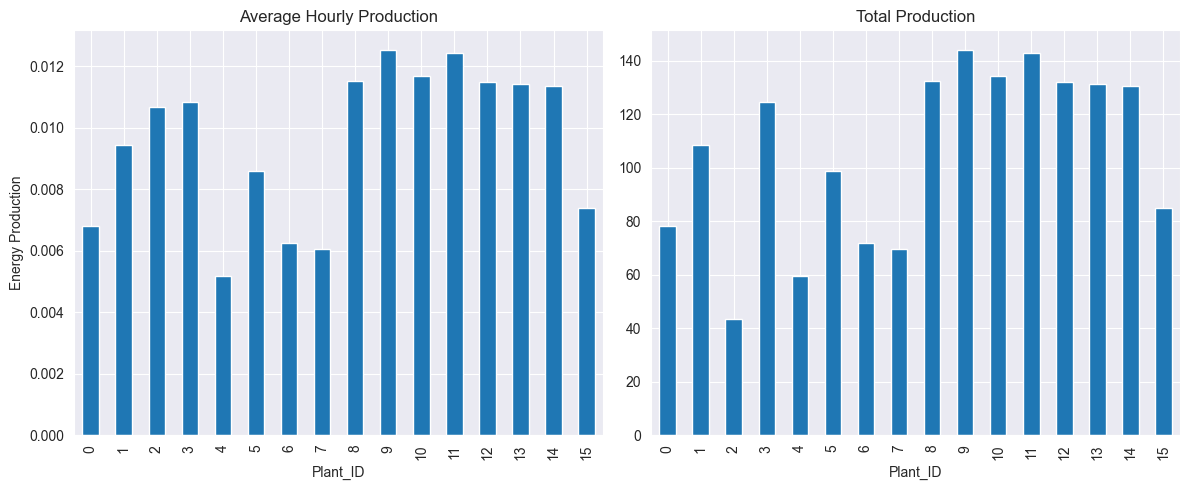

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

train_df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

train_df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

### Plot Correlations

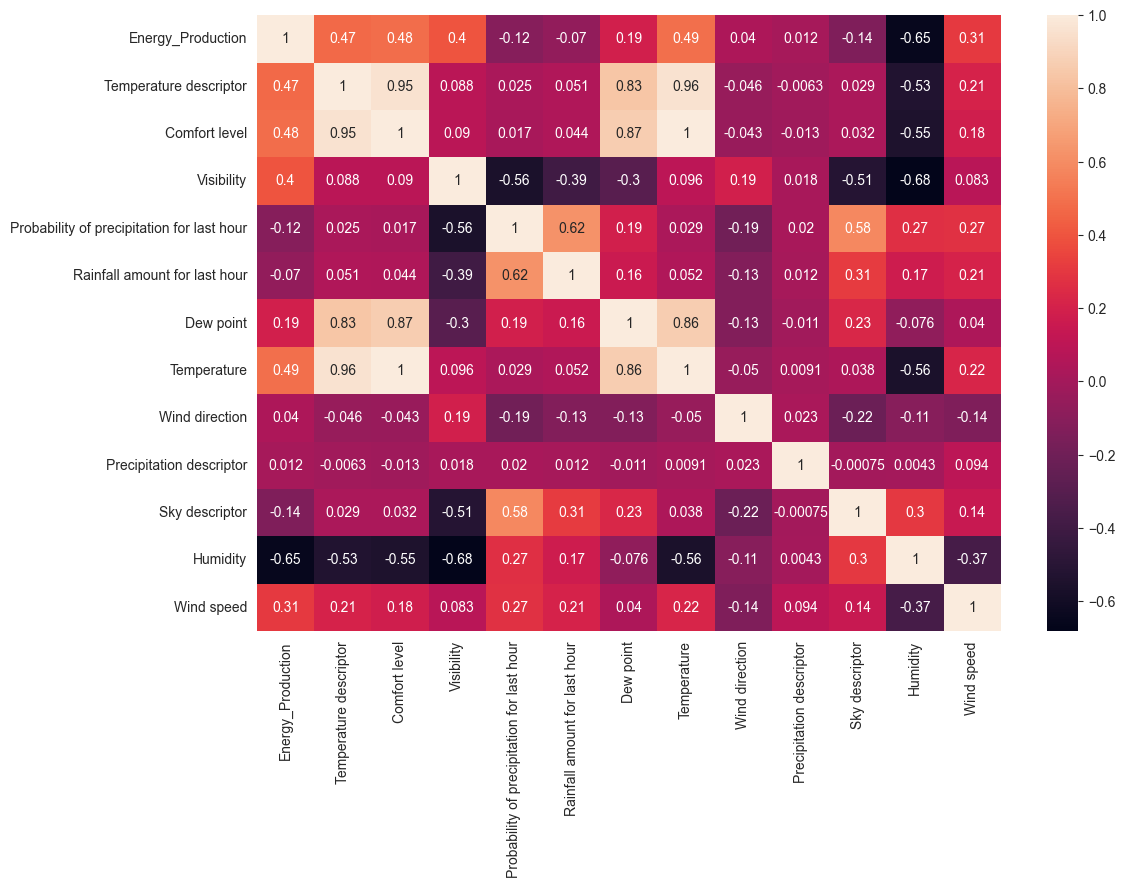

In [7]:
corr = train_df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()

### Plot Average Production by Hour of the Day

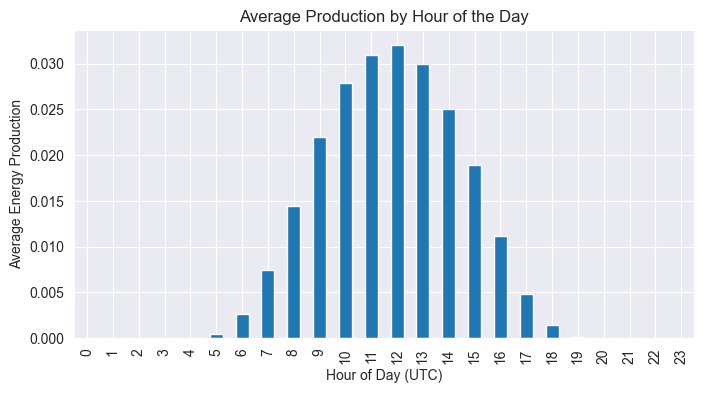

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

train_df['UTC Time'] = pd.to_datetime(train_df['UTC Time'])
train_df['hour'] = train_df['UTC Time'].dt.hour

(
    train_df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()

### Variance by plant

In [9]:
plant_variance = (train_df.groupby('Plant_ID')['Energy_Production'].agg(
          variance='var',
          std='std',
          mean='mean',
          count='count')
      .sort_values('variance', ascending=False))

display(plant_variance)

variance       std      mean  count
Plant_ID                                     
9         0.000366  0.019122  0.012543  11495
11        0.000353  0.018781  0.012435  11495
10        0.000319  0.017873  0.011692  11495
13        0.000316  0.017767  0.011424  11495
8         0.000313  0.017699  0.011513  11495
12        0.000305  0.017472  0.011482  11495
14        0.000298  0.017273  0.011365  11495
3         0.000286  0.016919  0.010838  11495
2         0.000247  0.015703  0.010683   4080
1         0.000220  0.014841  0.009457  11495
5         0.000180  0.013410  0.008600  11495
15        0.000126  0.011245  0.007379  11495
0         0.000126  0.011207  0.006816  11495
6         0.000092  0.009600  0.006253  11495
7         0.000087  0.009344  0.006058  11495
4         0.000068  0.008274  0.005186  11495

In [10]:
train_raw = train_df.copy()
test_raw  = test_df.copy()

train_raw = train_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)
test_raw  = test_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)

## Part 2: Feature Engineering

### Cyclical Feature Encoding

Some variables represent cyclical phenomena rather than linear quantities.

- Hour of day (0–23) is cyclical: hour 23 is close to hour 0.
- Wind direction (0–359°) is circular: 359° is close to 0°.

To preserve this structure, we apply sine and cosine transformations. This allows machine learning models to learn smooth periodic patterns
without artificial discontinuities.

In [11]:
def add_time_and_cyclical_features(d):
    d = d.copy()
    d["UTC Time"] = pd.to_datetime(d["UTC Time"], errors="coerce")
    d["hour"] = d["UTC Time"].dt.hour

    d["hour_sin"] = np.sin(2 * np.pi * d["hour"] / 24)
    d["hour_cos"] = np.cos(2 * np.pi * d["hour"] / 24)

    d["wind_dir_sin"] = np.sin(np.deg2rad(d["Wind direction"]))
    d["wind_dir_cos"] = np.cos(np.deg2rad(d["Wind direction"]))
    return d

### Panel-Safe Lag and Rolling Features

The dataset is panel data, with observations indexed by `Plant_ID` and `UTC time`. To avoid data leakage:
- All lagged and rolling features are computed **for each plant**
- Rolling statistics only use **past values** via `.shift(1)`
- The data is sorted by time before feature construction

These features allow the model to capture short-term persistence and
local trends in energy production.

In [12]:
def add_panel_lags_and_rolls(d, lags=(1, 3, 6, 12, 24), windows=(3, 6, 12, 24)):
    d = d.copy()
    d = d.sort_values(["Plant_ID", "UTC Time"]).reset_index(drop=True)

    # Lags (panel-safe)
    for lag in lags:
        d[f"Energy_Production_lag_{lag}"] = (
            d.groupby("Plant_ID")["Energy_Production"].shift(lag)
        )

    # Rolling stats (panel-safe: past-only via shift(1), rolled within each plant)
    shifted = d.groupby("Plant_ID")["Energy_Production"].shift(1)

    for w in windows:
        d[f"EP_roll_mean_{w}"] = (
            shifted.groupby(d["Plant_ID"])
                   .rolling(window=w, min_periods=w)
                   .mean()
                   .reset_index(level=0, drop=True)
        )
        d[f"EP_roll_std_{w}"] = (
            shifted.groupby(d["Plant_ID"])
                   .rolling(window=w, min_periods=w)
                   .std()
                   .reset_index(level=0, drop=True)
        )

    return d

# Apply functions
train_feat = add_panel_lags_and_rolls(add_time_and_cyclical_features(train_raw))
test_feat  = add_panel_lags_and_rolls(add_time_and_cyclical_features(test_raw))

print("train_feat shape:", train_feat.shape)
print("test_feat shape :", test_feat.shape)

train_feat shape: (176505, 35)
test_feat shape : (59376, 35)


# Part 3: Model Selection & Tuning

In this step we:
1. Build a leakage proof Train/Validation split (no shuffling, last 30% as validation).
2. Compare multiple model families:
   - Linear: Ridge, Lasso
   - Distance-based: KNN
   - Tree-based: Random Forest
   - Boosting: Gradient Boosting, LGBM and XGBoost
3. Evaluate all models using:
   - RMSE
   - R²

We implement the two strategies:
- **Global Model**: one model trained on all plants using `Plant_ID` as a feature.
- **Local Models**: one model per `Plant_ID` (15 separate models), then aggregate performance.

### Define target, features, and time-based validation split

We set:
- `Energy_Production` as the target
- a feature matrix that excludes the target, benchmark, and timestamp

Validation design:
- Use **unique timestamps** to define the 70/30 cutoff (avoids inconsistencies due to multiple plants per time).
- Train uses all rows with `UTC Time` ≤ cutoff; validation uses strictly later times.

In [13]:
TARGET_COL = "Energy_Production"
BENCH_COL  = "Benchmark"
TIME_COL   = "UTC Time"
PLANT_COL  = "Plant_ID"

# Features (everything except target/benchmark/time)
drop_cols = [TARGET_COL, BENCH_COL, TIME_COL]
feature_cols_eval = [c for c in train_feat.columns if c not in drop_cols]

# Full training set
X_full = train_feat[feature_cols_eval].copy()
y_full = train_feat[TARGET_COL].copy()

# True held-out test set (the provided test file)
X_test = test_feat[feature_cols_eval].copy()
y_test = test_feat[TARGET_COL].copy()

# Use unique times to avoid issues with multiple plants per timestamp
times = np.sort(train_feat[TIME_COL].dropna().unique())
cut_idx = int(0.7 * len(times))  # 70% cutoff
cut_time = times[cut_idx - 1]    # last time in train portion

train_mask = train_feat[TIME_COL] <= cut_time
val_mask   = train_feat[TIME_COL] > cut_time

X_train = X_full.loc[train_mask].copy()
y_train = y_full.loc[train_mask].copy()

X_val = X_full.loc[val_mask].copy()
y_val = y_full.loc[val_mask].copy()

print("Split cutoff time:", cut_time)
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

Split cutoff time: 2020-12-08 05:00:00+00:00
X_train: (124770, 32) X_val: (51735, 32) X_test: (59376, 32)


### Identify numeric vs categorical columns for preprocessing

We separate predictors into:
- **weather numeric columns**
- **other numeric columns**
- **categorical columns**

In [14]:
weather_num_cols = [
    "Visibility",
    "Probability of precipitation for last hour",
    "Rainfall amount for last hour",
    "Dew point",
    "Temperature",
    "Humidity",
    "Wind speed",
]

weather_num_cols = [c for c in weather_num_cols if c in X_train.columns]

num_cols_all = X_train.select_dtypes(include=[np.number]).columns.tolist()
other_num_cols = [c for c in num_cols_all if c not in weather_num_cols]

categorical_cols = [c for c in X_train.columns if c not in set(weather_num_cols + other_num_cols)]

### Pre-processing

We build a unified preprocessing block applied inside each model pipeline:

- **Weather numeric features**: median imputation → standardization → **PCA (retain 95% variance)**
  Rationale: weather variables are often correlated; PCA reduces dimensionality and multicollinearity.

- **Other numeric features**: median imputation → standardization
  Rationale: keep engineered signals in their original feature space.

- **Categorical features**: most-frequent imputation → one-hot encoding
  Rationale: produce a robust fixed design matrix and handle unseen categories in validation/test.

The `ColumnTransformer` ensures each feature group receives the appropriate transformation while dropping any unspecified columns.

In [34]:
# Preprocess
weather_num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
])

other_num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("weather_pca", weather_num_preprocess, weather_num_cols),
        ("num", other_num_preprocess, other_num_cols),
        ("cat", categorical_preprocess, categorical_cols),
    ],
    remainder="drop"
)

### Implementing Global Models and parameters

We compare multiple regression families under a single preprocessing pipeline:

- **Linear baselines**: Ridge, Lasso
  Strong reference points; effective when relationships are approximately linear after preprocessing.

- **Instance-based**: KNN
  Captures local nonlinearities but can be sensitive to feature scaling (handled by the pipeline).

- **Tree ensembles**: Random Forest, Gradient Boosting
  Nonlinear, robust to interactions; often strong general-purpose tabular baselines.

- **Modern boosting**: XGBoost, LightGBM
  Typically high-performing for structured data; tuned over a compact grid to balance performance and runtime.

Implementation details:
- Each model is wrapped in a `Pipeline(preprocess → model)` to prevent leakage (transformers are fit only on training folds).
- `param_grids` uses the `model__` prefix to target estimator hyperparameters inside the pipeline.

In [38]:
# Models + grids
models = {
    "Ridge": Pipeline([("prep", preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
    "XGBoost": Pipeline([("prep", preprocess), ("model", XGBRegressor(objective="reg:squarederror", random_state=42, n_estimators=400, n_jobs=-1))]),
    "LightGBM": Pipeline([("prep", preprocess), ("model", LGBMRegressor(random_state=42, n_estimators=400, n_jobs=-1, verbose=-1))]),
}


param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1]},
    "KNN":   {"model__n_neighbors": [5, 15, 30], "model__weights": ["uniform", "distance"]},

    "RandomForest": {
        "model__n_estimators": [200],
        "model__max_depth": [None, 10, 20]
    },

    "GradBoost": {
        "model__n_estimators": [200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3]
    },

    "XGBoost": {
        "model__max_depth": [3, 5],
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0],
        "model__min_child_weight": [1, 5],
        "model__reg_lambda": [1.0, 5.0]
    },

    "LightGBM": {
        "model__num_leaves": [31, 63],
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0],
        "model__min_child_samples": [10, 30],
        "model__reg_lambda": [0.0, 1.0]
    }
}

### Evaluation Metrics Set-up

In [39]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_train_test(fitted, Xtr, ytr, Xte, yte):
    pred_tr = np.clip(fitted.predict(Xtr), 0, None)
    pred_te = np.clip(fitted.predict(Xte), 0, None)
    return (
        rmse(ytr, pred_tr), float(r2_score(ytr, pred_tr)),
        rmse(yte, pred_te), float(r2_score(yte, pred_te)),
        pred_te
    )

### 3.5 Hyperparameter tuning with a single chronological split

We tune each model using **one fixed time-based split** (the 70/30 Train/Validation cut):

- Concatenate `X_train` and `X_val` into a single tuning dataset (`X_tune`).
- Provide `GridSearchCV` with an explicit `(train_idx, val_idx)` pair so that cross-validation respects time ordering.
- Use **RMSE** as the selection metric (`neg_root_mean_squared_error`).

Evaluation protocol:
1. Run grid search on `X_tune` using the fixed split to select `best_params`.
2. Fit the best configuration on **train only** and report **train/val** metrics (clean validation).
3. Refit the best configuration on **train+val** and evaluate on the **held-out test set**.

We store:
- `results_all`: summary table of RMSE/R² across train/val/test
- `best_estimators`: refit pipelines ready for final predictions
- `test_predictions`: test-set predictions for later comparison/plots

In [40]:
# Combine train+val into one dataset for GridSearchCV with a single time split
X_tune = pd.concat([X_train, X_val], axis=0)
y_tune = pd.concat([y_train, y_val], axis=0)

train_idx = np.arange(len(X_train))
val_idx   = np.arange(len(X_train), len(X_train) + len(X_val))
cv_one_split = [(train_idx, val_idx)]

rows = []
test_predictions = {}
best_estimators = {}

for name, pipe in models.items():
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=cv_one_split,
        n_jobs=-1,
        refit=False
    )
    grid.fit(X_tune, y_tune)

    # Fit best params on train only (so val metrics are clean)
    best_params = grid.best_params_
    best = pipe.set_params(**best_params)
    best.fit(X_train, y_train)

    # Evaluate on train + val
    pred_tr = np.clip(best.predict(X_train), 0, None)
    pred_va = np.clip(best.predict(X_val), 0, None)

    rmse_tr, r2_tr = rmse(y_train, pred_tr), float(r2_score(y_train, pred_tr))
    rmse_va, r2_va = rmse(y_val, pred_va), float(r2_score(y_val, pred_va))

    # Refit on train+val for final test evaluation
    best_refit = pipe.set_params(**best_params)
    best_refit.fit(X_tune, y_tune)

    pred_te = np.clip(best_refit.predict(X_test), 0, None)
    rmse_te, r2_te = rmse(y_test, pred_te), float(r2_score(y_test, pred_te))

    test_predictions[name] = pred_te
    best_estimators[name] = best_refit

    rows.append({
        "model": name,
        "rmse_train": rmse_tr, "r2_train": r2_tr,
        "rmse_val": rmse_va,   "r2_val": r2_va,
        "rmse_test": rmse_te,  "r2_test": r2_te,
        "best_params": best_params
    })

results_all = pd.DataFrame(rows).sort_values("rmse_val").reset_index(drop=True)
display(results_all)

best_global_name = results_all.iloc[0]["model"]
best_global_pipe = best_estimators[best_global_name]
print("Best GLOBAL model (by VAL RMSE):", best_global_name)

model    rmse_train  r2_train  rmse_val    r2_val  rmse_test  \
0      LightGBM  1.905793e-03  0.986139  0.002856  0.951363   0.002905   
1       XGBoost  2.230029e-03  0.981021  0.002873  0.950788   0.002884   
2     GradBoost  2.994570e-03  0.965777  0.002922  0.949097   0.002925   
3  RandomForest  7.951297e-04  0.997587  0.002987  0.946811   0.003011   
4         Ridge  3.650891e-03  0.949131  0.003235  0.937607   0.003207   
5         Lasso  3.802090e-03  0.944831  0.003347  0.933223   0.003261   
6           KNN  3.011218e-09  1.000000  0.003537  0.925395   0.003392   

    r2_test                                        best_params  
0  0.936213  {'model__colsample_bytree': 0.8, 'model__learn...  
1  0.937116  {'model__colsample_bytree': 1.0, 'model__learn...  
2  0.935336  {'model__learning_rate': 0.1, 'model__max_dept...  
3  0.931476  {'model__max_depth': 20, 'model__n_estimators'...  
4  0.922264                              {'model__alpha': 0.1}  
5  0.919640                           {'model__alpha': 0.0001}  
6  0.913024  {'model__n_neighbors': 30, 'model__weights': '...

Best GLOBAL model (by VAL RMSE): LightGBM


### Prediction, Benchmark and True plot - Global Models

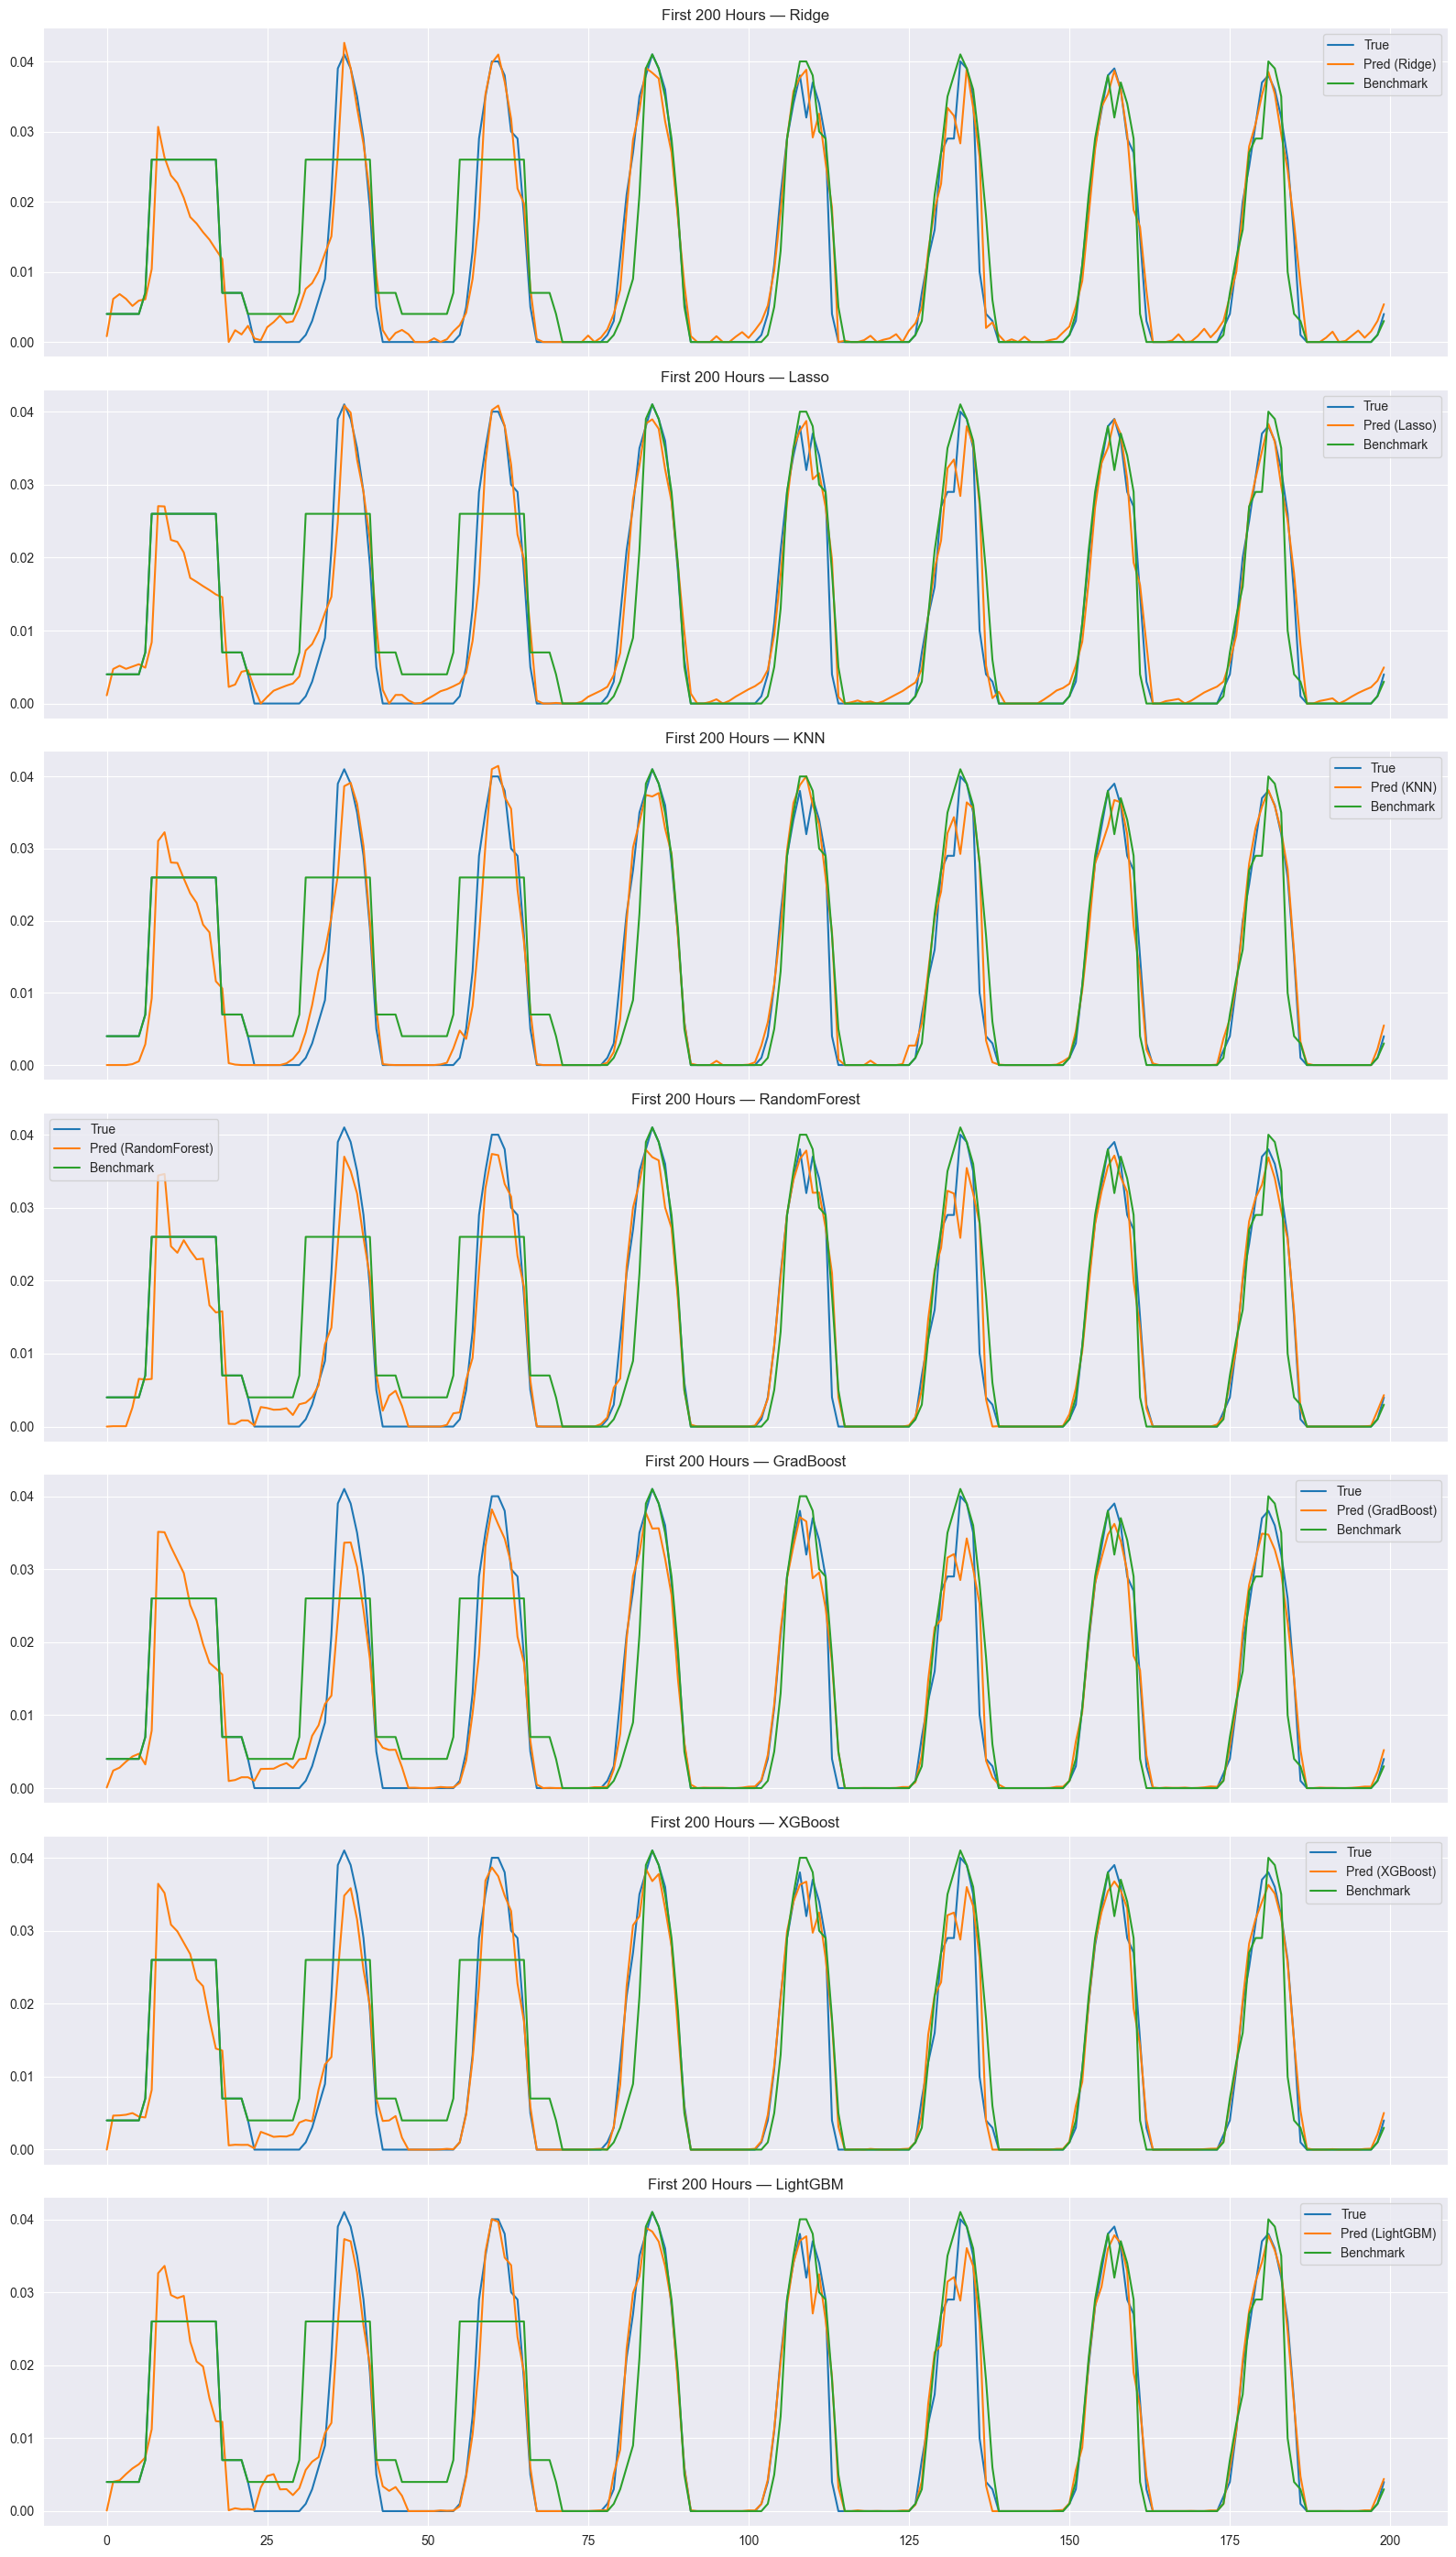

In [41]:
models_to_plot = [m for m in test_predictions.keys()]  # all ML models
n = 200
y_true = y_test.values[:n]
y_bench = np.clip(test_feat[BENCH_COL].values[:n], 0, None)

fig, axes = plt.subplots(len(models_to_plot), 1, figsize=(16, 4*len(models_to_plot)), sharex=True)

if len(models_to_plot) == 1:
    axes = [axes]

for ax, m in zip(axes, models_to_plot):
    ax.plot(y_true, label="True")
    ax.plot(test_predictions[m][:n], label=f"Pred ({m})")
    ax.plot(y_bench, label="Benchmark")
    ax.set_title(f"First {n} Hours — {m}")
    ax.legend()

plt.tight_layout()
plt.show()

### Implementing Local Models

For **local modeling**, we train a separate model for each `Plant_ID`.

Key implications:
- `Plant_ID` is constant within a plant, so we remove it from the feature set.
- Preprocessing is re-built for the local feature space (numeric/categorical detection must be done **after** dropping `Plant_ID`).
- The same transformation logic is reused (weather PCA, numeric scaling, categorical encoding), but applied within each plant’s model pipeline.

### Features and pre-processing

We define:
- `local_feature_cols` are predictors except `Plant_ID`
- local column groups for preprocessing:
  - weather numeric
  - other numeric
  - categorical

The resulting `local_preprocess` transformer will be used inside each per-plant model pipeline.


In [42]:
PLANT_COL = "Plant_ID"

# Local features: remove Plant_ID because within plant it is constant
local_feature_cols = [c for c in feature_cols_eval if c != PLANT_COL]

# Build X/y "templates" for dtype detection (important!)
X_local_template = train_feat[local_feature_cols].copy()

# Weather cols restricted to those that exist in the LOCAL feature set
local_weather_num_cols = [c for c in weather_num_cols if c in local_feature_cols]

# Other numeric = numeric but NOT weather
local_num_cols_all = X_local_template.select_dtypes(include=[np.number]).columns.tolist()
local_other_num_cols = [c for c in local_num_cols_all if c not in local_weather_num_cols]

# Categoricals
local_categorical_cols = [c for c in X_local_template.columns if c not in set(local_weather_num_cols + local_other_num_cols)]

local_weather_num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
])

local_other_num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

local_categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

local_preprocess = ColumnTransformer(
    transformers=[
        ("weather_pca", local_weather_num_preprocess, local_weather_num_cols),
        ("num", local_other_num_preprocess, local_other_num_cols),
        ("cat", local_categorical_preprocess, local_categorical_cols),
    ],
    remainder="drop"
)

### Model Set-Up

We reuse the same set of model families as in the global benchmark, but each model is trained **within a single plant** using the `local_preprocess` transformer.

In [43]:
local_models = {
    "Ridge": Pipeline([("prep", local_preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", local_preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", local_preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline([
        ("prep", local_preprocess),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
    "GradBoost": Pipeline([
        ("prep", local_preprocess),
        ("model", GradientBoostingRegressor(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("prep", local_preprocess),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_estimators=400,
            n_jobs=-1
        ))
    ]),
    "LightGBM": Pipeline([
        ("prep", local_preprocess),
        ("model", LGBMRegressor(
            random_state=42,
            n_estimators=400,
            n_jobs=-1,
            verbose=-1
        ))
    ]),
}

### Per-plant tuning and evaluation

For each `Plant_ID`, we train and evaluate **local** models using the same time-respecting protocol as the global benchmark:

Per plant:
- Sort observations by `UTC Time`.
- Create a **70/30 chronological split** using unique timestamps (train = earlier times, validation = later times).
- Tune hyperparameters with `GridSearchCV` using a **single fixed split** (`cv=[(train_idx, val_idx)]`) to preserve time order.

Evaluation protocol (per model, per plant):
1. Select `best_params` via grid search on `(train + val)` with the fixed split.
2. Fit the best configuration on **train only** and compute **train/validation** RMSE and R².
3. Refit on **train + val** and compute **test** RMSE and R² for that plant.

Outputs:
- `local_results_df`: performance table by plant and model (sorted by validation RMSE).
- `local_test_predictions`: per-plant test predictions (true values, predictions, timestamps, and benchmark where available) for later plotting and diagnostics.

In [44]:
local_param_grids = param_grids

LOCAL_TRAIN_FRAC = 0.7

local_rows = []
local_test_predictions = {}

plant_ids = sorted(train_feat[PLANT_COL].unique())

for pid in plant_ids:
    tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values("UTC Time")
    te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values("UTC Time")

    if len(tr_p) < 200 or len(te_p) < 50:
        print(f"Skipping Plant {pid}: train_rows={len(tr_p)} test_rows={len(te_p)}")
        continue

    times_p = np.sort(tr_p[TIME_COL].dropna().unique())
    cut_idx_p = int(LOCAL_TRAIN_FRAC * len(times_p))

    # safety guard (prevents cut_idx_p - 1 issues)
    if cut_idx_p < 1 or cut_idx_p >= len(times_p):
        print(f"Skipping Plant {pid}: not enough unique times ({len(times_p)}) for split")
        continue

    cut_time_p = times_p[cut_idx_p - 1]

    mask_tr = tr_p[TIME_COL] <= cut_time_p
    mask_va = tr_p[TIME_COL] > cut_time_p

    X_tr = tr_p.loc[mask_tr, local_feature_cols].copy()
    y_tr = tr_p.loc[mask_tr, TARGET_COL].copy()

    X_va = tr_p.loc[mask_va, local_feature_cols].copy()
    y_va = tr_p.loc[mask_va, TARGET_COL].copy()

    X_te = te_p[local_feature_cols].copy()
    y_te = te_p[TARGET_COL].copy()

    # Tune on (train+val) with ONE split (train_idx, val_idx)
    X_tune_p = pd.concat([X_tr, X_va], axis=0)
    y_tune_p = pd.concat([y_tr, y_va], axis=0)

    train_idx = np.arange(len(X_tr))
    val_idx   = np.arange(len(X_tr), len(X_tr) + len(X_va))
    cv_one_split_p = [(train_idx, val_idx)]

    for model_name, pipe in local_models.items():
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=local_param_grids[model_name],
            scoring="neg_root_mean_squared_error",
            cv=cv_one_split_p,
            n_jobs=-1,
            refit=False
        )
        grid.fit(X_tune_p, y_tune_p)

        best_params = grid.best_params_

        # Fit best params on TRAIN only
        best = pipe.set_params(**best_params)
        best.fit(X_tr, y_tr)

        pred_tr = np.clip(best.predict(X_tr), 0, None)
        pred_va = np.clip(best.predict(X_va), 0, None)

        rmse_tr, r2_tr = rmse(y_tr, pred_tr), float(r2_score(y_tr, pred_tr))
        rmse_va, r2_va = rmse(y_va, pred_va), float(r2_score(y_va, pred_va))

        # Refit on (train+val) for final TEST evaluation
        best_refit = pipe.set_params(**best_params)
        best_refit.fit(X_tune_p, y_tune_p)

        pred_te = np.clip(best_refit.predict(X_te), 0, None)
        rmse_te, r2_te = rmse(y_te, pred_te), float(r2_score(y_te, pred_te))

        local_rows.append({
            "Plant_ID": pid,
            "model": f"Local-{model_name}",
            "rmse_train": rmse_tr,
            "r2_train": r2_tr,
            "rmse_val": rmse_va,
            "r2_val": r2_va,
            "rmse_test": rmse_te,
            "r2_test": r2_te,
            "best_params": best_params
        })

        local_test_predictions[(pid, model_name)] = {
            "y_true": y_te.values,
            "y_pred": pred_te,
            "utc_time": te_p[TIME_COL].values,
            "benchmark": np.clip(te_p[BENCH_COL].values, 0, None) if BENCH_COL in te_p.columns else None
        }

local_results_df = pd.DataFrame(local_rows).sort_values(["Plant_ID", "rmse_val"])
display(local_results_df)

Plant_ID               model    rmse_train  r2_train  rmse_val    r2_val  \
5           0       Local-XGBoost  2.032356e-03  0.969877  0.002369  0.941622   
4           0     Local-GradBoost  2.174759e-03  0.965507  0.002396  0.940283   
6           0      Local-LightGBM  1.061841e-03  0.991777  0.002419  0.939155   
3           0  Local-RandomForest  9.366075e-04  0.993602  0.002462  0.936949   
0           0         Local-Ridge  2.700548e-03  0.946813  0.002521  0.933886   
..        ...                 ...           ...       ...       ...       ...   
109        15     Local-GradBoost  2.145501e-03  0.966644  0.002311  0.943838   
108        15  Local-RandomForest  8.946914e-04  0.994199  0.002312  0.943802   
105        15         Local-Ridge  2.616243e-03  0.950400  0.002477  0.935502   
106        15         Local-Lasso  2.759529e-03  0.944819  0.002575  0.930328   
107        15           Local-KNN  1.139281e-09  1.000000  0.002695  0.923651   

     rmse_test   r2_test                                        best_params  
5     0.001870  0.946618  {'model__colsample_bytree': 1.0, 'model__learn...  
4     0.001916  0.943962  {'model__learning_rate': 0.05, 'model__max_dep...  
6     0.001901  0.944812  {'model__colsample_bytree': 0.8, 'model__learn...  
3     0.001927  0.943294  {'model__max_depth': 20, 'model__n_estimators'...  
0     0.001991  0.939498                             {'model__alpha': 10.0}  
..         ...       ...                                                ...  
109   0.002087  0.939661  {'model__learning_rate': 0.05, 'model__max_dep...  
108   0.002114  0.938093  {'model__max_depth': None, 'model__n_estimator...  
105   0.002189  0.933623                              {'model__alpha': 0.1}  
106   0.002251  0.929804                           {'model__alpha': 0.0001}  
107   0.002452  0.916725  {'model__n_neighbors': 15, 'model__weights': '...  

[112 rows x 9 columns]

#### Average metrics per model family across plants

In [23]:
local_summary_by_model = (
    local_results_df
    .groupby("model")[["rmse_train", "r2_train", "rmse_val", "r2_val", "rmse_test", "r2_test"]]
    .mean()
    .sort_values("rmse_val")
)

display(local_summary_by_model)

rmse_train  r2_train  rmse_val    r2_val  rmse_test  \
model                                                                       
Local-XGBoost       2.305729e-03  0.977181  0.002923  0.946993   0.002798   
Local-GradBoost     2.727390e-03  0.968788  0.002957  0.945634   0.002847   
Local-LightGBM      1.169974e-03  0.993818  0.002963  0.945550   0.002849   
Local-RandomForest  1.316286e-03  0.992305  0.003008  0.943828   0.002866   
Local-Ridge         3.459016e-03  0.949876  0.003215  0.936008   0.003051   
Local-Lasso         3.620329e-03  0.944877  0.003320  0.931589   0.003088   
Local-KNN           1.833112e-09  1.000000  0.003561  0.921756   0.003326   

                     r2_test  
model                         
Local-XGBoost       0.932492  
Local-GradBoost     0.929573  
Local-LightGBM      0.929771  
Local-RandomForest  0.928826  
Local-Ridge         0.919680  
Local-Lasso         0.917836  
Local-KNN           0.903322

#### Best local model per plant (select by lowest test RMSE)

In [25]:
best_local_per_plant = (
    local_results_df
    .sort_values(["Plant_ID", "rmse_val"])
    .drop_duplicates(subset=["Plant_ID"], keep="first")
    .reset_index(drop=True)
)

display(best_local_per_plant)

Plants in best_local_per_plant: 16


Plant_ID           model  rmse_train  r2_train  rmse_val    r2_val  \
0          0   Local-XGBoost    0.002032  0.969877  0.002369  0.941622   
1          1   Local-XGBoost    0.002560  0.973616  0.002814  0.944771   
2          2  Local-LightGBM    0.000443  0.999066  0.004633  0.931139   
3          3   Local-XGBoost    0.001861  0.989617  0.002679  0.953553   
4          4   Local-XGBoost    0.001472  0.972052  0.001541  0.946030   
5          5   Local-XGBoost    0.002423  0.970730  0.002526  0.948356   
6          6   Local-XGBoost    0.001123  0.987820  0.001780  0.947851   
7          7   Local-XGBoost    0.000970  0.990498  0.001667  0.949701   
8          8   Local-XGBoost    0.001969  0.988930  0.003177  0.952796   
9          9   Local-XGBoost    0.003322  0.972204  0.003855  0.947096   
10        10   Local-XGBoost    0.003086  0.972210  0.003697  0.946782   
11        11   Local-XGBoost    0.003281  0.971780  0.003771  0.948364   
12        12   Local-XGBoost    0.003135  0.971151  0.003209  0.950946   
13        13   Local-XGBoost    0.003075  0.972645  0.003430  0.950284   
14        14   Local-XGBoost    0.002661  0.978635  0.003253  0.949441   
15        15   Local-XGBoost    0.002031  0.970123  0.002260  0.946290   

    rmse_test   r2_test                                        best_params  
0    0.001870  0.946618  {'model__colsample_bytree': 1.0, 'model__learn...  
1    0.002613  0.924988  {'model__colsample_bytree': 0.8, 'model__learn...  
2    0.003466  0.899691  {'model__colsample_bytree': 1.0, 'model__learn...  
3    0.003632  0.916531  {'model__colsample_bytree': 0.8, 'model__learn...  
4    0.001363  0.910447  {'model__colsample_bytree': 0.8, 'model__learn...  
5    0.002294  0.939099  {'model__colsample_bytree': 0.8, 'model__learn...  
6    0.001885  0.927288  {'model__colsample_bytree': 0.8, 'model__learn...  
7    0.001489  0.945968  {'model__colsample_bytree': 0.8, 'model__learn...  
8    0.003355  0.927379  {'model__colsample_bytree': 1.0, 'model__learn...  
9    0.003729  0.941889  {'model__colsample_bytree': 0.8, 'model__learn...  
10   0.003687  0.930401  {'model__colsample_bytree': 1.0, 'model__learn...  
11   0.003732  0.940041  {'model__colsample_bytree': 1.0, 'model__learn...  
12   0.003146  0.940634  {'model__colsample_bytree': 1.0, 'model__learn...  
13   0.003619  0.941112  {'model__colsample_bytree': 1.0, 'model__learn...  
14   0.003120  0.930655  {'model__colsample_bytree': 1.0, 'model__learn...  
15   0.002059  0.941297  {'model__colsample_bytree': 0.8, 'model__learn...

#### C) “Local strategy overall score” (mean of best per-plant models)

In [26]:
local_best_overall = best_local_per_plant[["rmse_train", "r2_train", "rmse_test", "r2_test"]].mean()
print("Local strategy (best-per-plant average):")
display(local_best_overall.to_frame("mean_metric"))

Local strategy (best-per-plant average):


mean_metric
rmse_train     0.002215
r2_train       0.978185
rmse_test      0.002816
r2_test        0.931502

### Prediction, Benchmark and True plot - Local Models

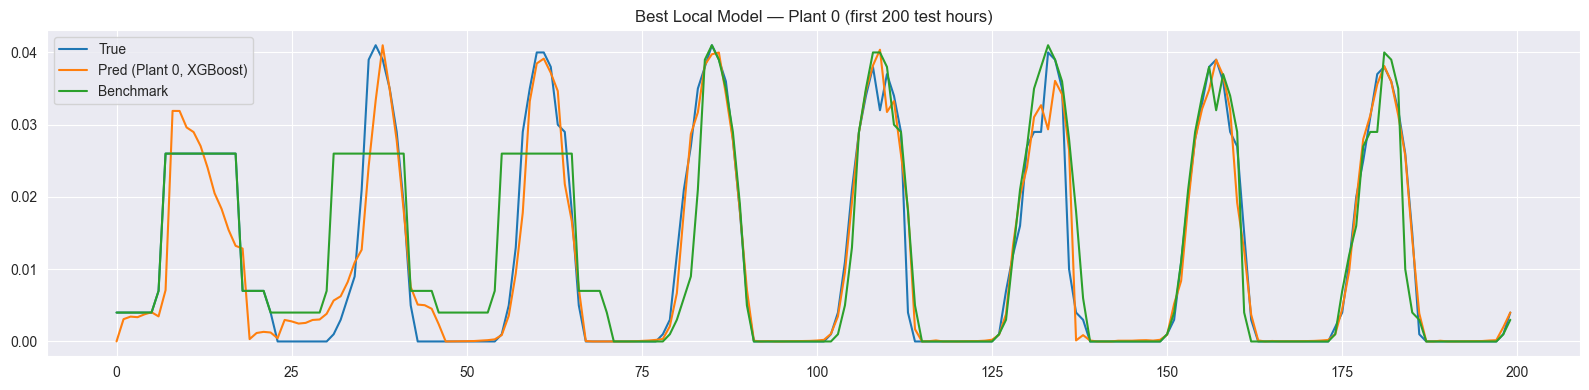

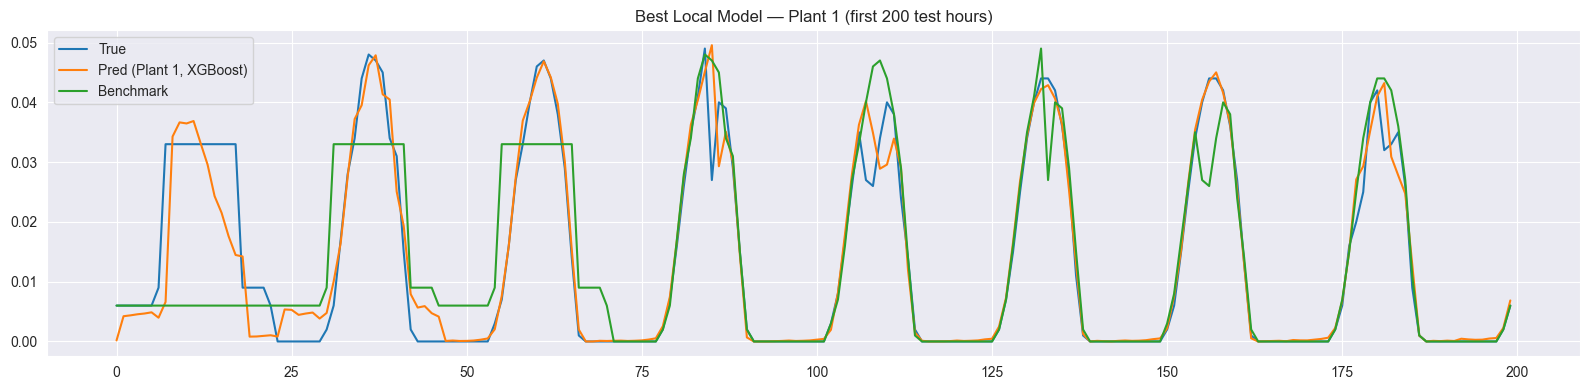

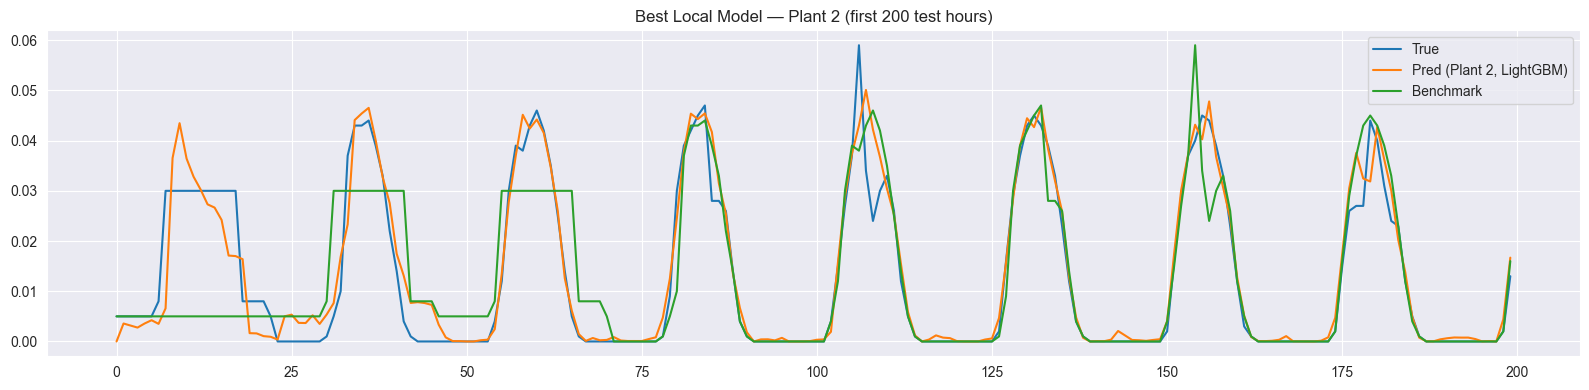

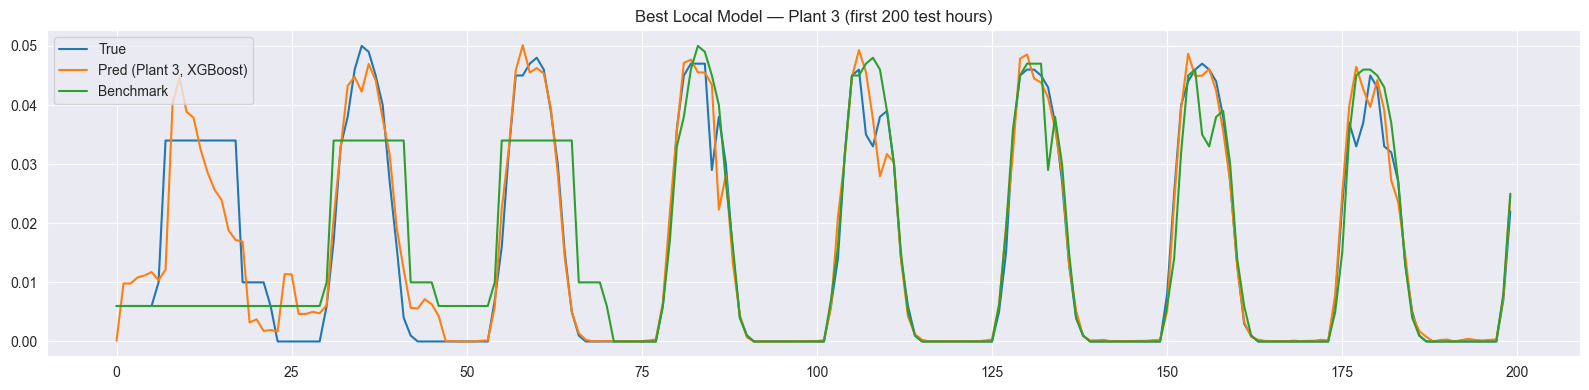

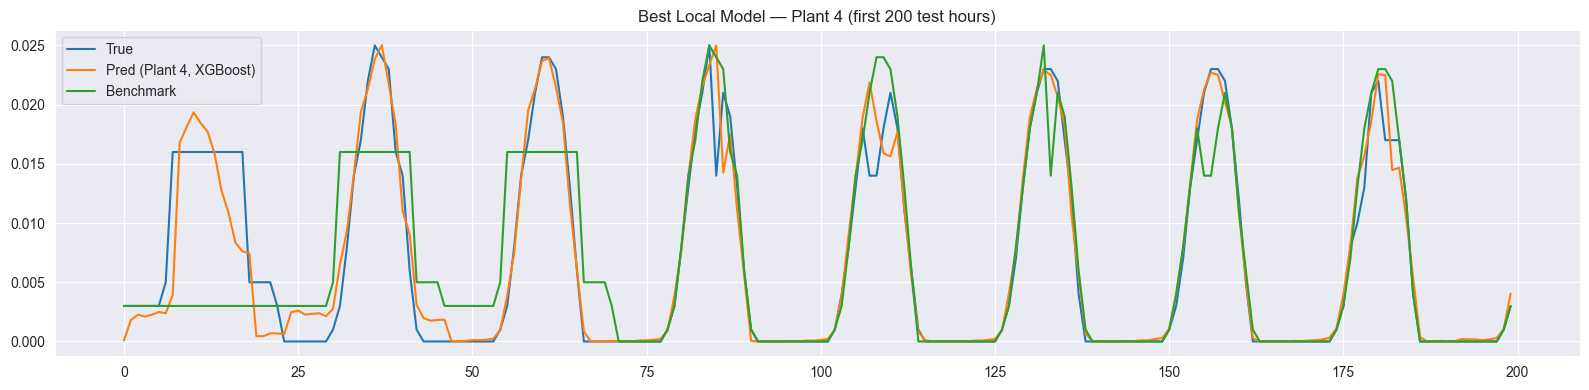

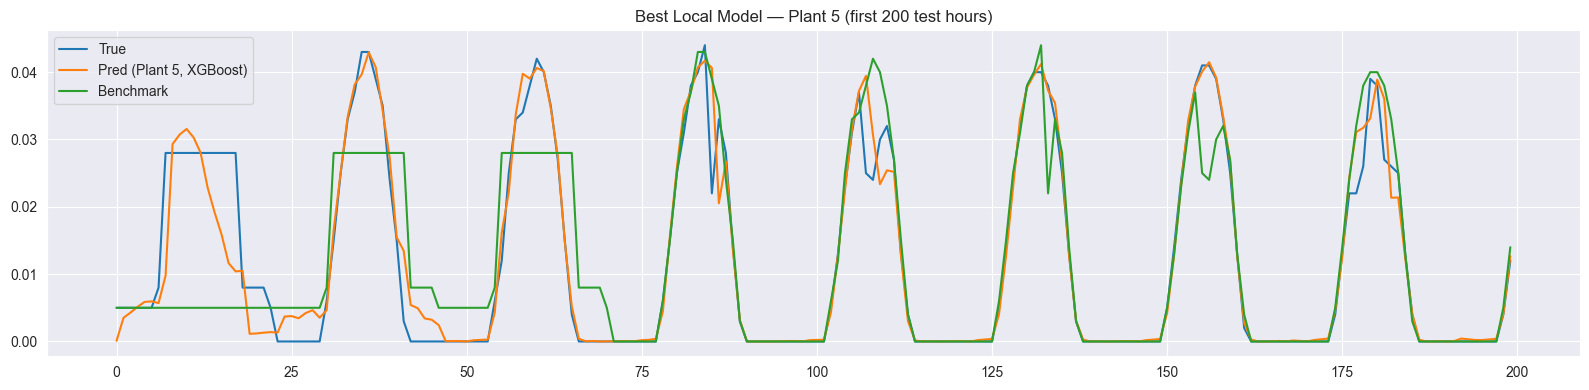

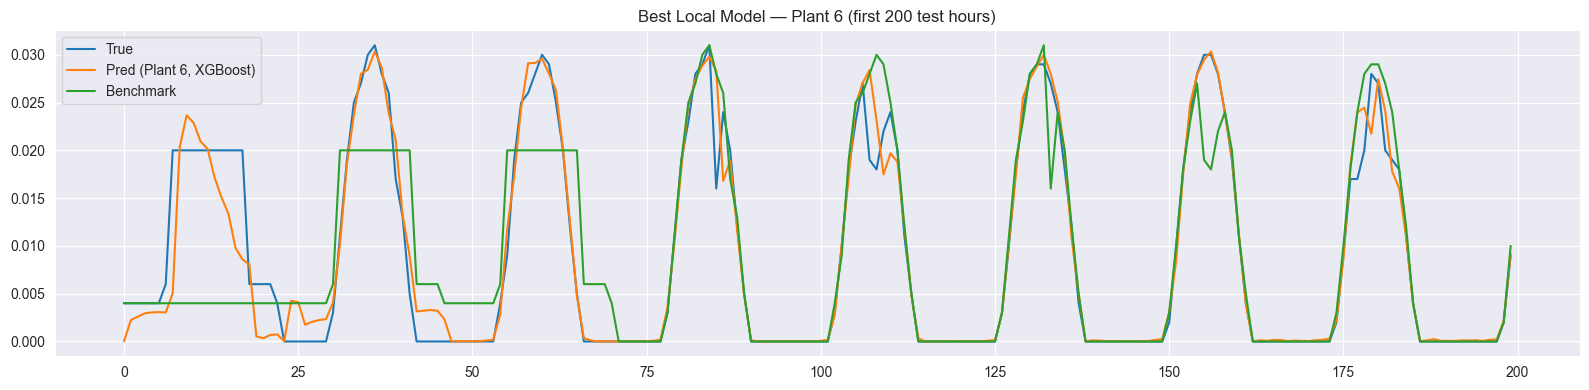

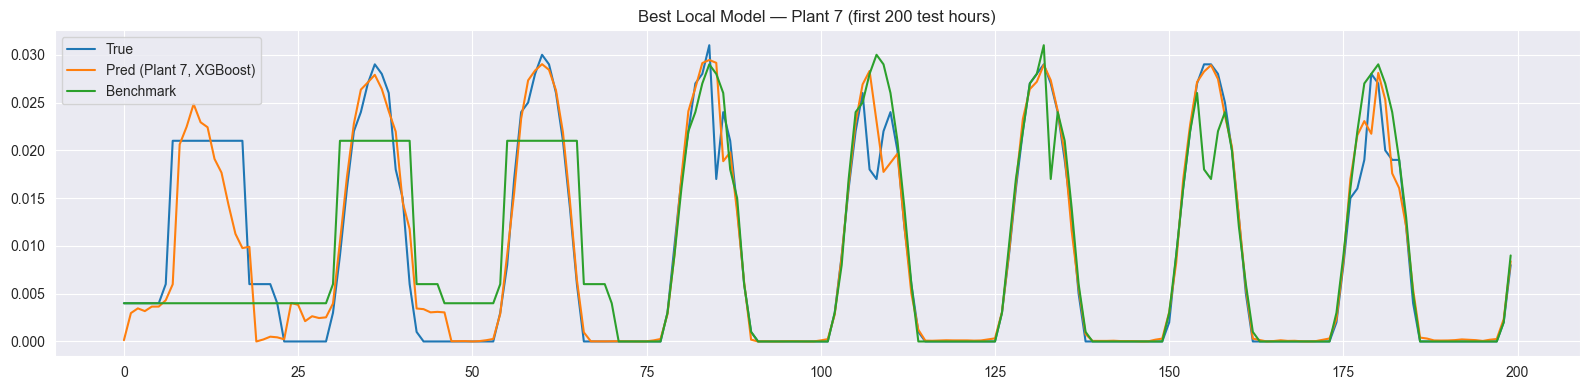

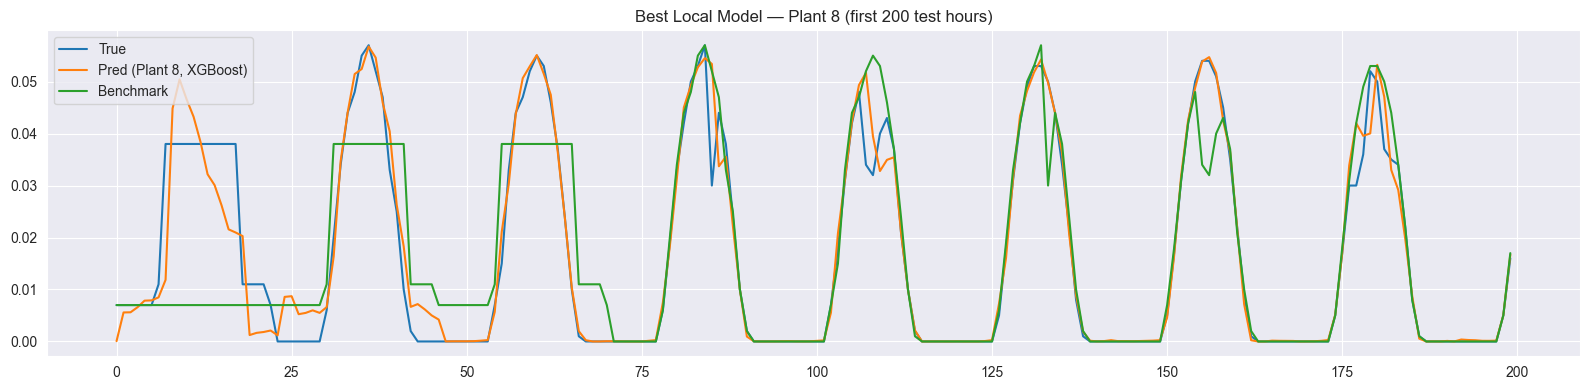

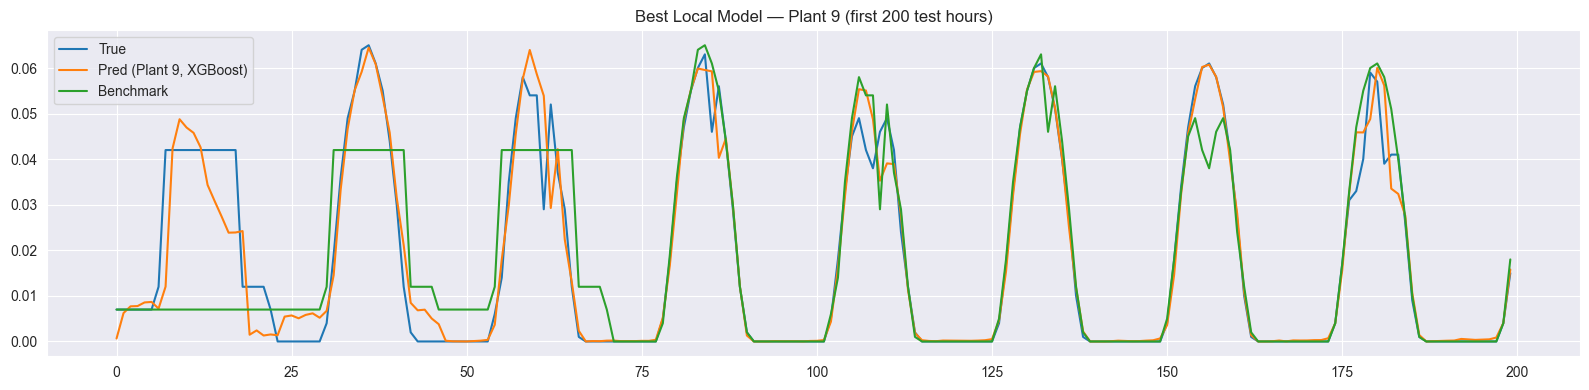

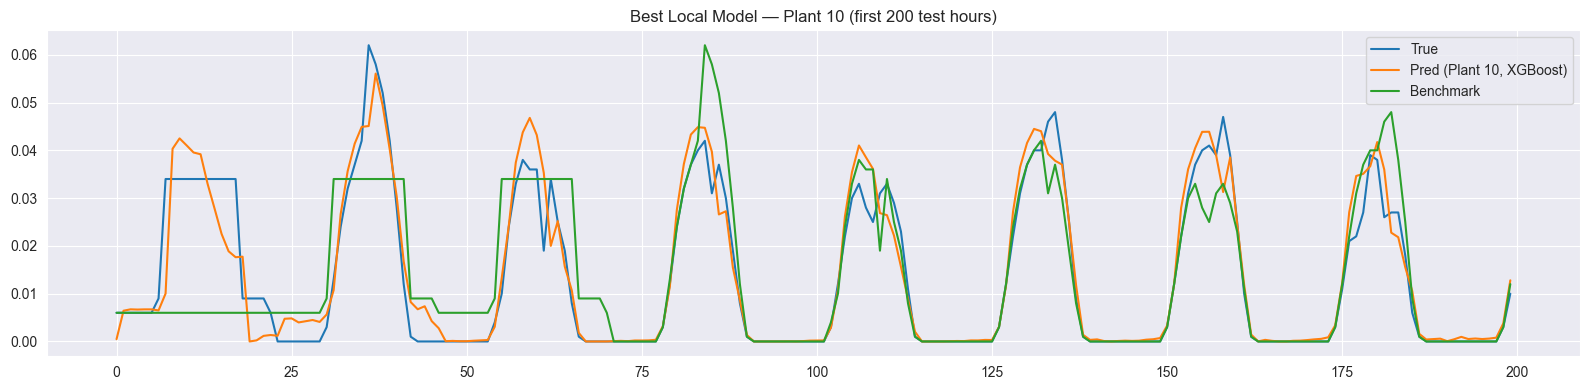

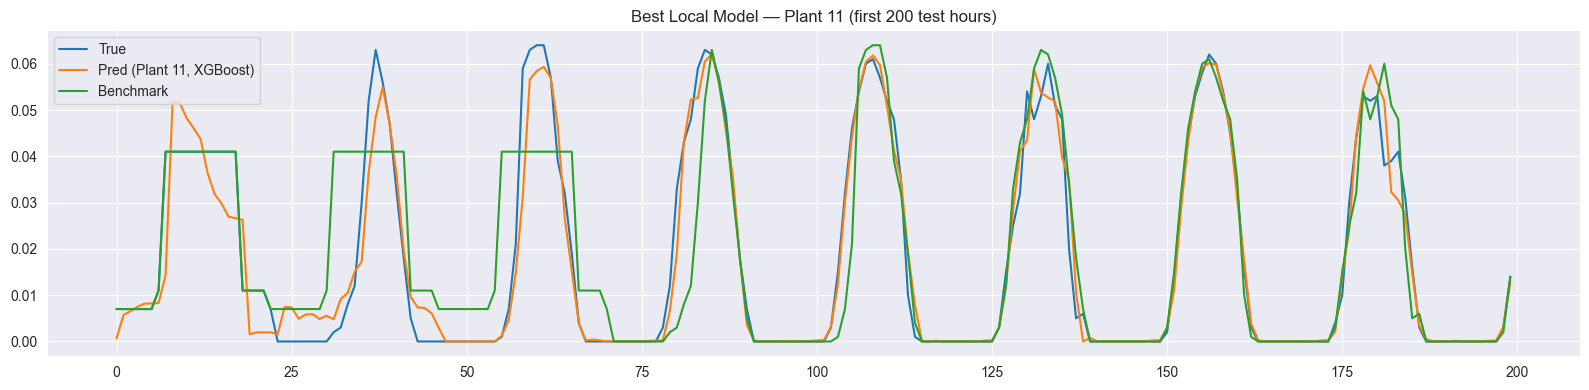

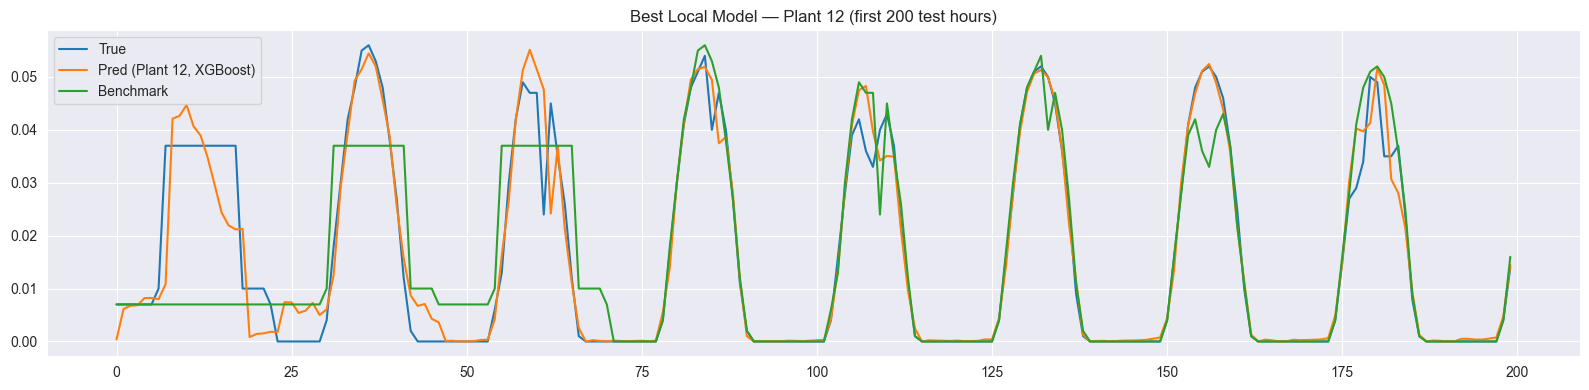

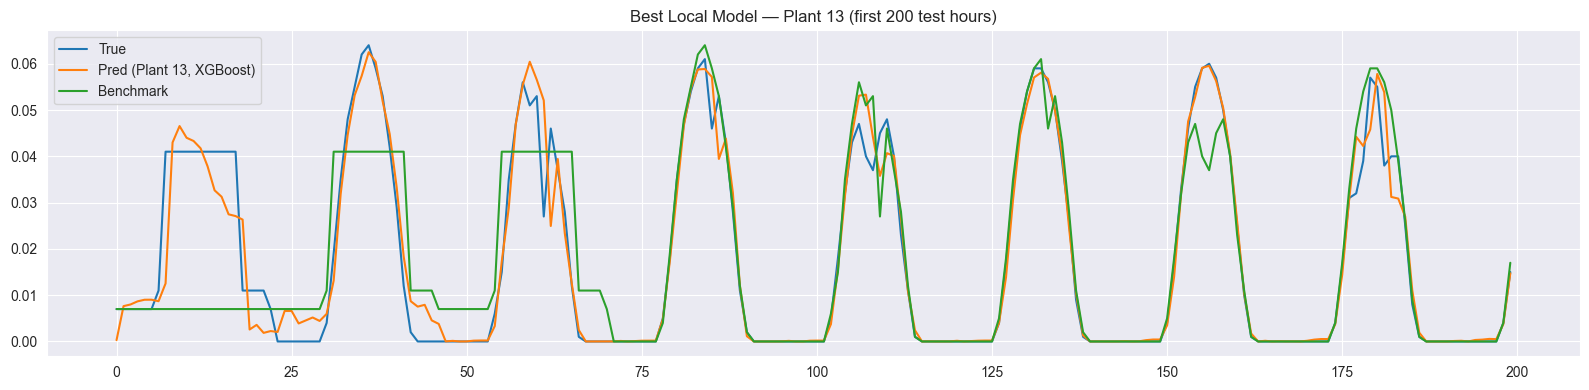

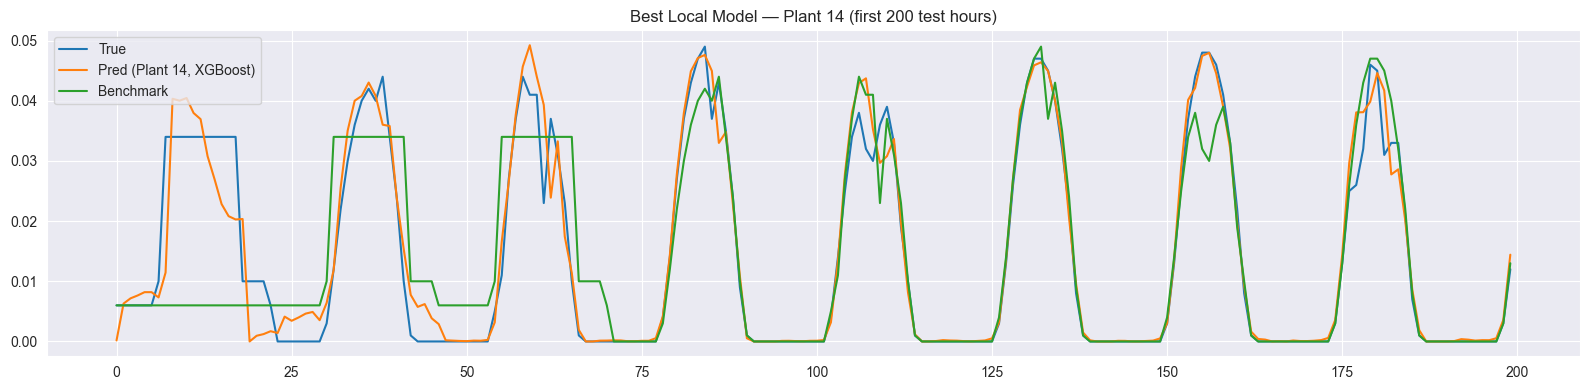

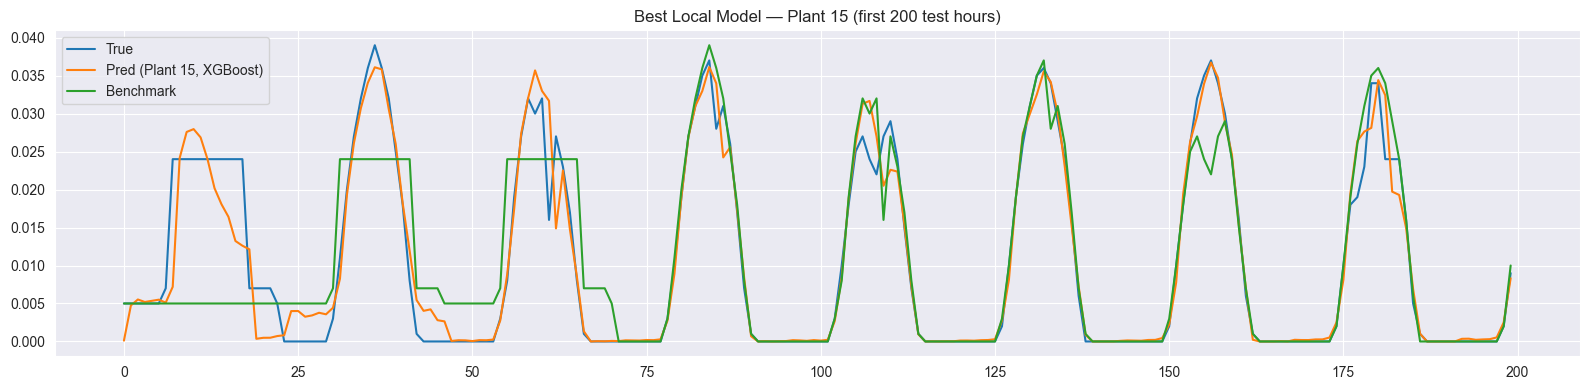

In [27]:
n = 200

for pid in sorted(best_local_per_plant["Plant_ID"].unique()):
    best_label = best_local_per_plant.loc[best_local_per_plant["Plant_ID"] == pid, "model"].iloc[0]
    model_name = best_label.replace("Local-", "")  # e.g. "XGBoost"

    key = (pid, model_name)
    if key not in local_test_predictions:
        print(f"Missing predictions for Plant {pid}, model {model_name}. Skipping.")
        continue

    pack = local_test_predictions[key]
    order = np.argsort(pack["utc_time"])

    y_true = pack["y_true"][order]
    y_pred = pack["y_pred"][order]
    y_bench = pack["benchmark"][order] if pack["benchmark"] is not None else None

    nn = min(n, len(y_true))

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y_true[:nn], label="True")
    ax.plot(y_pred[:nn], label=f"Pred (Plant {pid}, {model_name})")
    if y_bench is not None:
        ax.plot(y_bench[:nn], label="Benchmark")
    ax.set_title(f"Best Local Model — Plant {pid} (first {nn} test hours)")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Part 4: Model Interpretation (XAI)


Goal: explain the **best global model** using two complementary global methods:
- **Permutation importance** on the *original input columns* (model-agnostic).
- **SHAP** on the *transformed feature space* produced by preprocessing.

Interpretability note:
- Weather variables passed through **PCA** are represented as PCs (linear combinations of the original weather features).
- Engineered features (lags/rolls/cyclical) remain directly interpretable.

### Utilities and preconditions

We define small helpers for:
- subsampling (keep XAI runtime bounded)
- identifying tree-based estimators (to choose the SHAP explainer)
- parsing stored parameter dictionaries (used later for optional local sanity checks)

We also assert required global objects exist before running interpretation.

In [45]:
# XAI config to keep run time under control
CFG = dict(
    pi_subsample_n=1500,
    pi_repeats=2,
    pi_max_samples=0.6,
    pi_backend="threading",
    pi_n_jobs=-1,
    shap_subsample_n=500,
    shap_bg_n=150,
)

# Helpers
def safe_subsample_df(X, y, n=1000, seed=42):
    n = min(n, len(X))
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(X), size=n, replace=False)
    return X.iloc[idx], y.iloc[idx]

def is_tree_model(m):
    return m.__class__.__name__ in [
        "RandomForestRegressor", "GradientBoostingRegressor",
        "XGBRegressor", "LGBMRegressor"
    ]

def maybe_parse_params(x):
    # local_results_df["best_params"] might be dict or string
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return {}
    return {}

# Preconditions
assert "best_global_pipe" in globals(), "best_global_pipe not found. Run your GLOBAL tuning block first."
assert "X_test" in globals() and "y_test" in globals(), "X_test/y_test not found."

### 4.2 Global permutation importance (input features)

Permutation importance is **model-agnostic**:
- shuffle one feature at a time
- measure the performance drop (RMSE degradation)

We compute it on a subsample of the test set for speed, and report the top drivers.

feature  importance_mean  \
19                     Energy_Production_lag_1     8.160648e-03   
14                                        hour     1.273700e-03   
23                    Energy_Production_lag_24     8.529182e-04   
16                                    hour_cos     1.816393e-04   
11                              Sky descriptor     1.655736e-04   
25                               EP_roll_std_3     1.435704e-04   
27                               EP_roll_std_6     8.821433e-05   
4                                   Visibility     7.195052e-05   
5   Probability of precipitation for last hour     6.469514e-05   
18                                wind_dir_cos     3.639339e-05   
8                                  Temperature     2.771624e-05   
9                               Wind direction     1.828719e-05   
24                              EP_roll_mean_3     1.416030e-05   
12                                    Humidity     1.315268e-05   
7                                    Dew point     3.886710e-07   
15                                    hour_sin    -5.302647e-06   
30                             EP_roll_mean_24    -9.364067e-06   
0                                     Plant_ID    -1.134904e-05   
6                Rainfall amount for last hour    -1.288608e-05   
21                     Energy_Production_lag_6    -1.676115e-05   

    importance_std  
19    1.023013e-04  
14    1.115214e-04  
23    3.366641e-05  
16    3.831631e-05  
11    4.095279e-06  
25    1.232475e-05  
27    2.238504e-05  
4     3.071201e-05  
5     3.503971e-05  
18    7.581734e-06  
8     1.384809e-05  
9     1.763281e-05  
24    5.049126e-06  
12    4.745176e-06  
7     7.324478e-06  
15    2.557251e-05  
30    2.440235e-05  
0     5.850114e-08  
6     8.801712e-06  
21    1.232754e-06

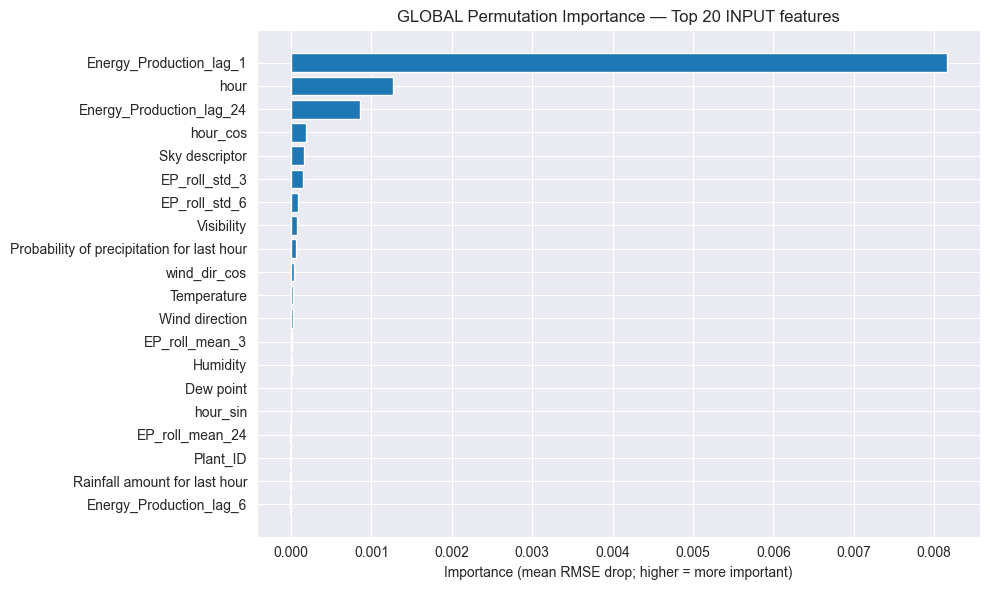

In [46]:
X_pi, y_pi = safe_subsample_df(X_test, y_test, n=CFG["pi_subsample_n"], seed=42)

with parallel_backend(CFG["pi_backend"]):
    perm = permutation_importance(
        best_global_pipe,
        X_pi,
        y_pi,
        scoring="neg_root_mean_squared_error",
        n_repeats=CFG["pi_repeats"],
        random_state=42,
        n_jobs=CFG["pi_n_jobs"],
        max_samples=CFG["pi_max_samples"],
    )

imp_df = pd.DataFrame({
    "feature": X_pi.columns.astype(str).to_numpy(),
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(20))

top_k = 20
plot_df = imp_df.head(top_k).iloc[::-1]
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_df["feature"], plot_df["importance_mean"])
ax.set_title(f"GLOBAL Permutation Importance — Top {top_k} INPUT features")
ax.set_xlabel("Importance (mean RMSE drop; higher = more important)")
plt.tight_layout()
plt.show()

### Global SHAP setup (work in transformed feature space)

SHAP explains contributions at the model input level. Because the best pipeline includes preprocessing:
- we extract `prep` and `model`
- we transform `X_test` using `prep.transform(...)`
- we retrieve transformed feature names (falls back to f0, f1, ... if unavailable)

We select the SHAP explainer based on model class:
- `TreeExplainer` for tree-based models
- generic `Explainer` for others

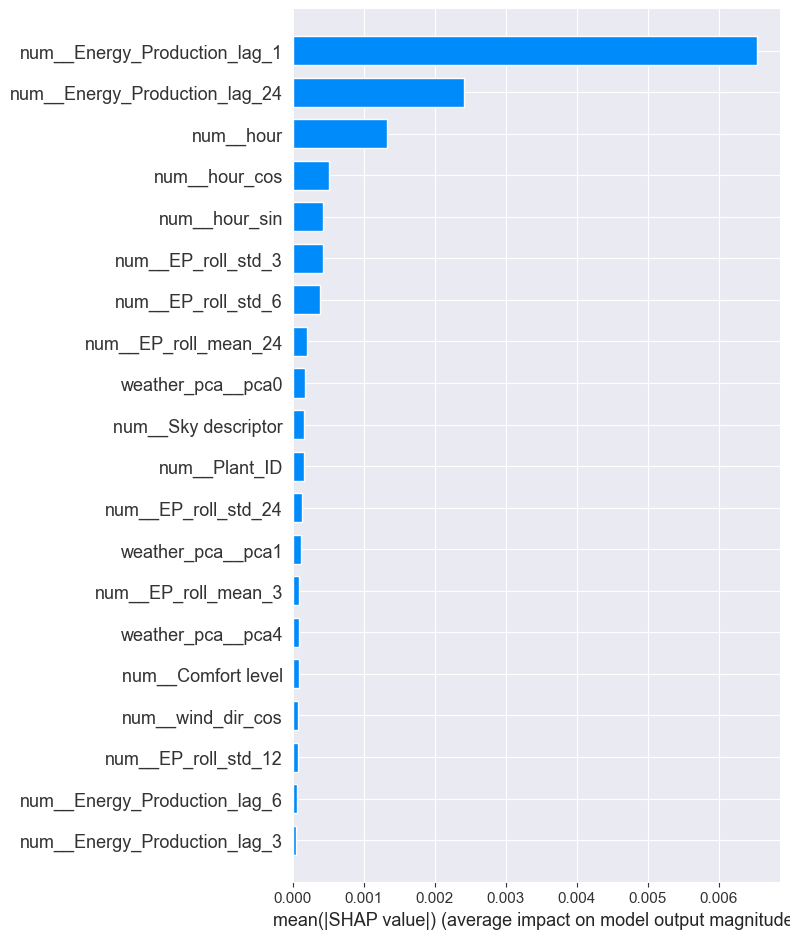

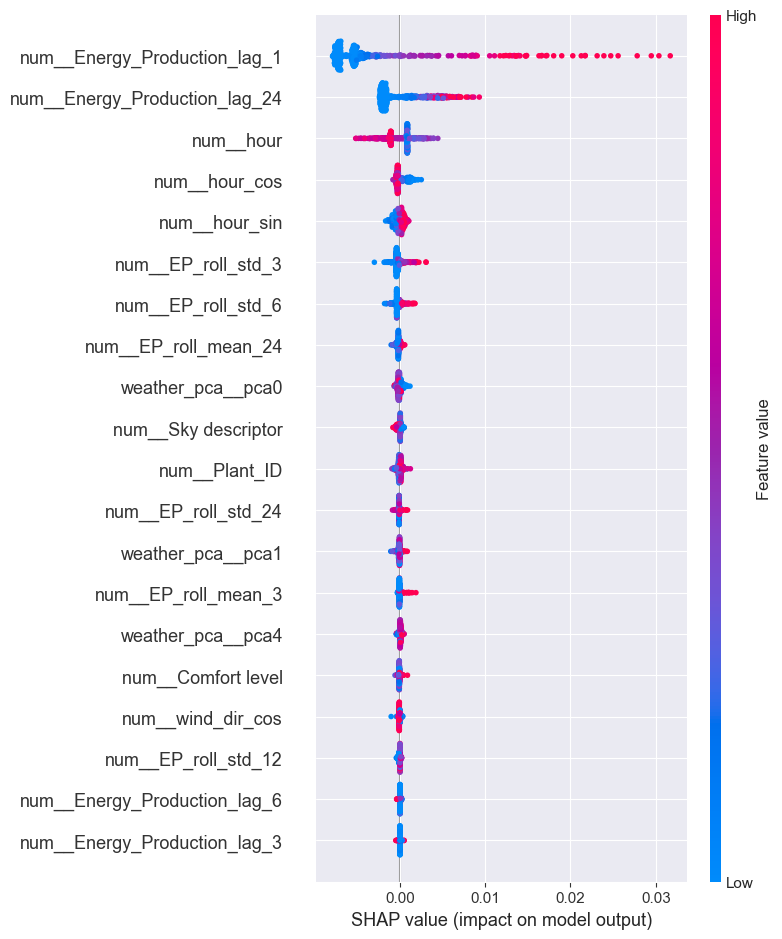

GLOBAL anomaly idx: 14648 | y_true: 0.097 | y_pred: 0.0008575596868287666 | abs_err: 0.09614244031317123


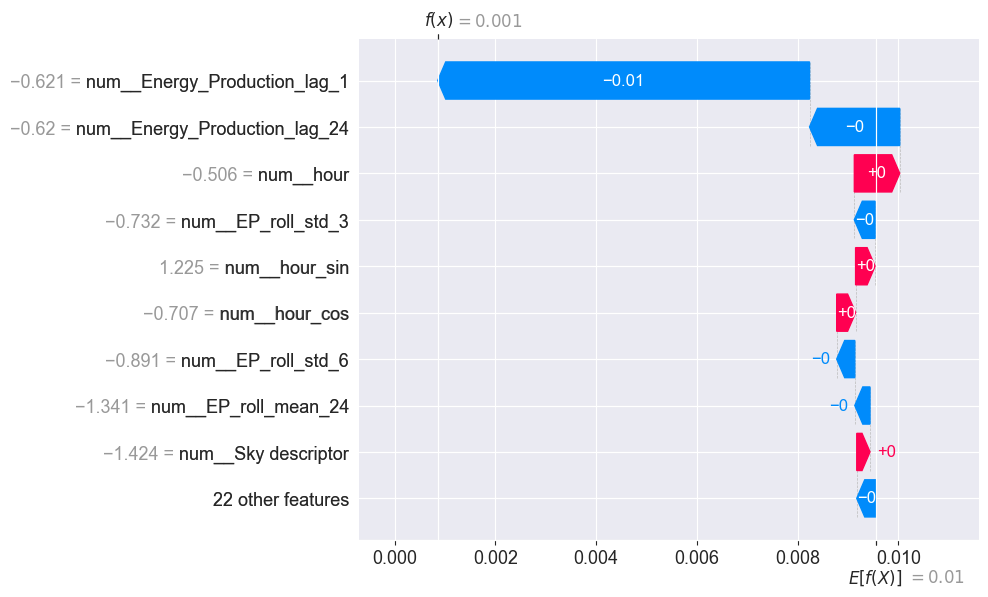

In [47]:
try:
    import shap

    prep_g = best_global_pipe.named_steps["prep"]
    model_g = best_global_pipe.named_steps["model"]

    X_shap, y_shap = safe_subsample_df(X_test, y_test, n=CFG["shap_subsample_n"], seed=7)
    X_shap_trans = prep_g.transform(X_shap)

    try:
        feat_names_trans = prep_g.get_feature_names_out()
    except Exception:
        feat_names_trans = [f"f{i}" for i in range(X_shap_trans.shape[1])]

    if is_tree_model(model_g):
        expl = shap.TreeExplainer(model_g)
        sv = expl.shap_values(X_shap_trans)
        shap.summary_plot(sv, X_shap_trans, feature_names=feat_names_trans, plot_type="bar", max_display=20)
        shap.summary_plot(sv, X_shap_trans, feature_names=feat_names_trans, max_display=20)
    else:
        bg = X_shap_trans[:min(CFG["shap_bg_n"], X_shap_trans.shape[0])]
        expl = shap.Explainer(model_g, bg)
        sv = expl(X_shap_trans)
        shap.summary_plot(sv, feature_names=feat_names_trans, plot_type="bar", max_display=20)
        shap.summary_plot(sv, feature_names=feat_names_trans, max_display=20)

    # Biggest absolute error on full test -> waterfall
    y_pred_test = np.clip(best_global_pipe.predict(X_test), 0, None)
    abs_err = np.abs(y_test.values - y_pred_test)
    idx_anom = int(np.argmax(abs_err))

    print("GLOBAL anomaly idx:", idx_anom,
          "| y_true:", float(y_test.values[idx_anom]),
          "| y_pred:", float(y_pred_test[idx_anom]),
          "| abs_err:", float(abs_err[idx_anom]))

    x_row = X_test.iloc[[idx_anom]]
    x_row_trans = prep_g.transform(x_row)

    try:
        if is_tree_model(model_g):
            sv_row = expl.shap_values(x_row_trans)
            base_val = expl.expected_value
            exp = shap.Explanation(
                values=sv_row[0] if isinstance(sv_row, list) else sv_row[0],
                base_values=base_val if np.isscalar(base_val) else base_val[0],
                data=x_row_trans[0],
                feature_names=feat_names_trans
            )
            shap.plots.waterfall(exp)
        else:
            exp = expl(x_row_trans)
            shap.plots.waterfall(exp[0])
    except Exception as e:
        print("GLOBAL local SHAP failed:", repr(e))

except Exception as e:
    print("GLOBAL SHAP skipped/failed:", repr(e))


### One-plant local sanity plot

This mirrors the earlier plotting diagnostic (see the **test-set sanity plot** section),
but for a single plant’s best local model (selected by validation RMSE).

This is intentionally lightweight:
- reuse stored `best_params` from `local_results_df`
- fit on the full plant training data
- plot the first N hours of the plant test set vs benchmark


[Plant 0] best local model by VAL: XGBoost
[Plant 0] TEST RMSE=0.001870 | R2=0.9466


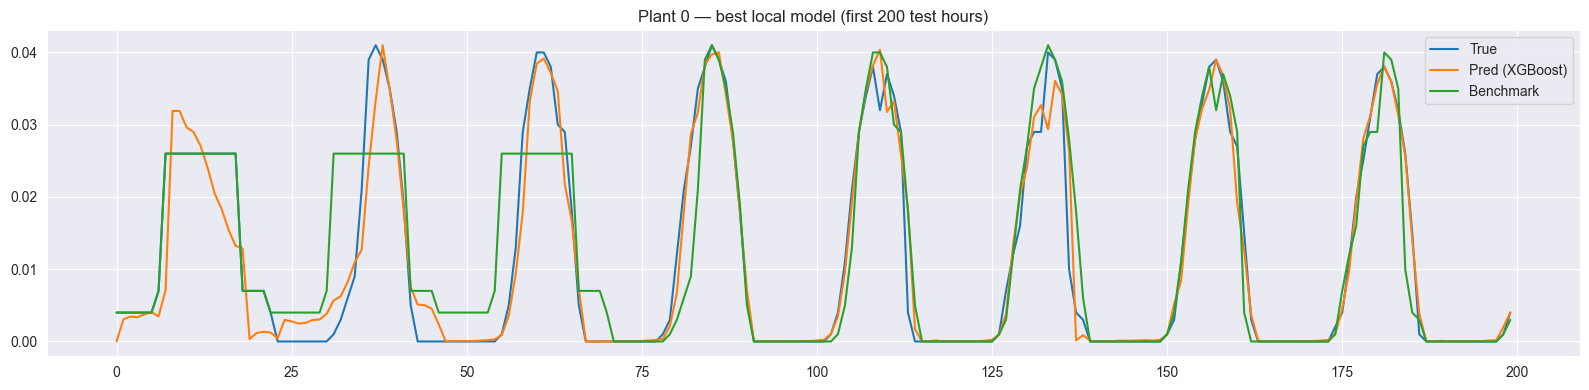

In [48]:
do_local_plot = all(k in globals() for k in [
    "local_results_df", "local_models", "local_feature_cols",
    "train_feat", "test_feat", "TARGET_COL", "TIME_COL", "PLANT_COL", "BENCH_COL"
])

if do_local_plot:
    pid = 0  # change if you want

    # pick best local model for this plant by VAL RMSE (aligned with your methodology)
    df_pid = local_results_df[local_results_df[PLANT_COL] == pid].sort_values("rmse_val")
    assert len(df_pid) > 0, f"No local results found for Plant {pid}."

    best_row = df_pid.iloc[0]
    best_label = best_row["model"]          # e.g. "Local-XGBoost"
    best_name = best_label.replace("Local-", "")
    best_params = maybe_parse_params(best_row.get("best_params", {}))

    print(f"[Plant {pid}] best local model by VAL: {best_name}")
    # Fit on FULL plant train (train file) using stored best_params, then evaluate on plant test (test file)
    tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values(TIME_COL)
    te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values(TIME_COL)

    X_tr_p = tr_p[local_feature_cols].copy()
    y_tr_p = tr_p[TARGET_COL].copy()
    X_te_p = te_p[local_feature_cols].copy()
    y_te_p = te_p[TARGET_COL].copy()

    pipe = local_models[best_name].set_params(**best_params)
    pipe.fit(X_tr_p, y_tr_p)

    pred_te = np.clip(pipe.predict(X_te_p), 0, None)
    print(f"[Plant {pid}] TEST RMSE={rmse(y_te_p, pred_te):.6f} | R2={float(r2_score(y_te_p, pred_te)):.4f}")

    # plot first N hours
    N = 200
    y_true = y_te_p.values[:N]
    y_hat  = pred_te[:N]
    y_bench = np.clip(te_p[BENCH_COL].values[:N], 0, None) if BENCH_COL in te_p.columns else None

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y_true, label="True")
    ax.plot(y_hat, label=f"Pred ({best_name})")
    if y_bench is not None:
        ax.plot(y_bench, label="Benchmark")
    ax.set_title(f"Plant {pid} — best local model (first {min(N, len(y_true))} test hours)")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Local sanity plot skipped (local_* variables not found).")

## Part 5

We quantify whether ML adds value relative to the provided `Benchmark` forecast.

We report:
- **GLOBAL**: best single model evaluated on the full test set
- **LOCAL**: best-per-plant local model averaged across plants on their plant-specific test sets

For RMSE, we also compute a **% improvement** relative to the benchmark.


We compare the best global pipeline against the benchmark on:
- training split
- held-out test set (main evaluation)

Implementation detail:
- we choose the “best global model” by **test RMSE** from the results table
- we use the corresponding fitted pipeline from `best_estimators` when available

In [49]:
# Best GLOBAL model vs Benchmark (from results_all)
results_tbl = results_all_fast if "results_all_fast" in globals() else results_all
best_global_name = results_tbl.loc[results_tbl["model"] != "Benchmark"].sort_values("rmse_test").iloc[0]["model"]
assert BENCH_COL in train_feat.columns and BENCH_COL in test_feat.columns, f"{BENCH_COL} missing from train_feat/test_feat."

# identify best non-benchmark row from results_all
best_global_name = results_all.loc[results_all["model"] != "Benchmark"].sort_values("rmse_test").iloc[0]["model"]

# predictions (global model)
yhat_tr = np.clip(best_global_pipe.predict(X_train), 0, None)
yhat_te = np.clip(best_global_pipe.predict(X_test), 0, None)

# benchmark predictions
ybench_tr = np.clip(train_feat.loc[X_train.index, BENCH_COL].values, 0, None)
ybench_te = np.clip(test_feat.loc[X_test.index,  BENCH_COL].values, 0, None)

global_comp = pd.DataFrame({
    "metric": ["RMSE_train", "R2_train", "RMSE_test", "R2_test"],
    "Best_Global_Model": [
        rmse(y_train, yhat_tr),
        float(r2_score(y_train, yhat_tr)),
        rmse(y_test, yhat_te),
        float(r2_score(y_test, yhat_te)),
    ],
    "Benchmark": [
        rmse(y_train, ybench_tr),
        float(r2_score(y_train, ybench_tr)),
        rmse(y_test, ybench_te),
        float(r2_score(y_test, ybench_te)),
    ]
})

global_comp["Delta (Model - Bench)"] = global_comp["Best_Global_Model"] - global_comp["Benchmark"]
global_comp["% Improvement (RMSE)"] = np.where(
    global_comp["metric"].str.contains("RMSE"),
    100 * (global_comp["Benchmark"] - global_comp["Best_Global_Model"]) / global_comp["Benchmark"],
    np.nan
)

print(f"Best GLOBAL model (by test RMSE): {best_global_name}")
display(global_comp)

Best GLOBAL model (by test RMSE): XGBoost


metric  Best_Global_Model  Benchmark  Delta (Model - Bench)  \
0  RMSE_train           0.002080   0.008100              -0.006020   
1    R2_train           0.983482   0.749589               0.233893   
2   RMSE_test           0.002905   0.007067              -0.004162   
3     R2_test           0.936213   0.622516               0.313697   

   % Improvement (RMSE)  
0             74.316423  
1                   NaN  
2             58.892942  
3                   NaN

###  Global Models veredict

In [50]:
# verdict text (global)
rmse_imp = float(global_comp.loc[global_comp["metric"] == "RMSE_test", "% Improvement (RMSE)"].iloc[0])
r2_model = float(global_comp.loc[global_comp["metric"] == "R2_test", "Best_Global_Model"].iloc[0])
r2_bench = float(global_comp.loc[global_comp["metric"] == "R2_test", "Benchmark"].iloc[0])

if rmse_imp > 0:
    verdict_global = (
        f"VERDICT (GLOBAL): ML adds value vs Benchmark on TEST — "
        f"RMSE improves by {rmse_imp:.2f}% and R² improves by {(r2_model - r2_bench):.4f}."
    )
else:
    verdict_global = (
        f"VERDICT (GLOBAL): ML does NOT beat Benchmark on TEST — "
        f"RMSE change {rmse_imp:.2f}% and R² change {(r2_model - r2_bench):.4f}."
    )

print(verdict_global)

VERDICT (GLOBAL): ML adds value vs Benchmark on TEST — RMSE improves by 58.89% and R² improves by 0.3137.


### LOCAL strategy vs Benchmark (mean over best-per-plant)


In [51]:
do_local = all(k in globals() for k in ["best_local_per_plant", "local_test_predictions"]) and ("Benchmark" in test_feat.columns)

if do_local:
    # compute per-plant benchmark RMSE/R2 + best-local RMSE/R2 on the PLANT test sets
    local_rows = []

    for pid in sorted(best_local_per_plant[PLANT_COL].unique()):
        best_label = best_local_per_plant.loc[best_local_per_plant[PLANT_COL] == pid, "model"].iloc[0]
        best_m = best_label.replace("Local-", "")
        key = (pid, best_m)

        if key not in local_test_predictions:
            continue

        pack = local_test_predictions[key]
        y_true = np.asarray(pack["y_true"])
        y_pred = np.asarray(pack["y_pred"])
        y_bench = pack.get("benchmark", None)

        if y_bench is None:
            continue

        y_bench = np.asarray(y_bench)

        local_rows.append({
            "Plant_ID": pid,
            "rmse_local": rmse(y_true, y_pred),
            "r2_local": float(r2_score(y_true, y_pred)),
            "rmse_bench": rmse(y_true, y_bench),
            "r2_bench": float(r2_score(y_true, y_bench)),
            "best_local_model": best_m
        })

    local_comp_df = pd.DataFrame(local_rows)

    if len(local_comp_df) > 0:
        local_summary = pd.Series({
            "RMSE_test_local_avg": float(local_comp_df["rmse_local"].mean()),
            "R2_test_local_avg": float(local_comp_df["r2_local"].mean()),
            "RMSE_test_bench_avg": float(local_comp_df["rmse_bench"].mean()),
            "R2_test_bench_avg": float(local_comp_df["r2_bench"].mean()),
        })

        local_rmse_imp = 100 * (local_summary["RMSE_test_bench_avg"] - local_summary["RMSE_test_local_avg"]) / local_summary["RMSE_test_bench_avg"]
        local_r2_delta = local_summary["R2_test_local_avg"] - local_summary["R2_test_bench_avg"]

        print("\nLOCAL strategy vs Benchmark (averaged across plants using each plant’s best local model):")
        display(local_summary.to_frame("value"))
        print(f"VERDICT (LOCAL): RMSE improvement = {local_rmse_imp:.2f}% | R² delta = {local_r2_delta:.4f}")

        # (optional) show which plants benefit most
        local_comp_df["rmse_improve_%"] = 100 * (local_comp_df["rmse_bench"] - local_comp_df["rmse_local"]) / local_comp_df["rmse_bench"]
        display(local_comp_df.sort_values("rmse_improve_%", ascending=False).head(10))
    else:
        print("\nLOCAL strategy comparison skipped: could not compute (missing benchmark vectors in local_test_predictions).")
else:
    print("\nLOCAL strategy comparison skipped (best_local_per_plant/local_test_predictions not found).")


LOCAL strategy vs Benchmark (averaged across plants using each plant’s best local model):


value
RMSE_test_local_avg  0.002816
R2_test_local_avg    0.931502
RMSE_test_bench_avg  0.006664
R2_test_bench_avg    0.632353

VERDICT (LOCAL): RMSE improvement = 57.74% | R² delta = 0.2991


Plant_ID  rmse_local  r2_local  rmse_bench  r2_bench best_local_model  \
9          9    0.003729  0.941889    0.010173  0.567400          XGBoost   
13        13    0.003619  0.941112    0.009634  0.582756          XGBoost   
10        10    0.003687  0.930401    0.009654  0.522769          XGBoost   
12        12    0.003146  0.940634    0.007983  0.617765          XGBoost   
15        15    0.002059  0.941297    0.005179  0.628464          XGBoost   
11        11    0.003732  0.940041    0.009372  0.621871          XGBoost   
14        14    0.003120  0.930655    0.007603  0.588236          XGBoost   
7          7    0.001489  0.945968    0.003470  0.706520          XGBoost   
5          5    0.002294  0.939099    0.005324  0.672024          XGBoost   
6          6    0.001885  0.927288    0.004238  0.632407          XGBoost   

    rmse_improve_%  
9        63.349155  
13       62.432086  
10       61.811110  
12       60.590342  
15       60.250511  
11       60.179335  
14       58.962179  
7        57.092050  
5        56.908688  
6        55.524688